# imports

In [1]:
from glob import glob
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import tensorflow as tf
from keras.applications.xception import preprocess_input as Optimized_preprocess
from keras.applications.vgg16 import VGG16, preprocess_input as VGG16_preprocess
from keras.applications.mobilenet import MobileNet, preprocess_input as MobileNet_preprocess
from keras.applications.resnet50 import ResNet50, preprocess_input as ResNet_preprocess
from keras import layers
from keras.models import Model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns; sns.set()

# read dataset

Los datos han sido descargado desde https://www.kaggle.com/ashishjangra27/gender-recognition-200k-images-celeba
el cual consta de 200k de imagenes de rostros de personas clasificadas por genero

La caracteristica de esta base de datos es que esta estandarizada por ubicacion de los ojos.

Esta base de datos se estructura de la siguiente manera:
  + data
    + Train
      - *.jpg
    + Validation
      - *.jpg
    + Test
      - *.jpg

In [2]:
data_set = ['Train', 'Validation', 'Test']
genders = ['Female', 'Male']

paths = './data/{dataSet}/{gender}*/*.jpg'

partition = {'train':      {'img': [], 'label': []},
             'validation': {'img': [], 'label': []},
             'test':       {'img': [], 'label': []},
             }

for dataSet in data_set:
  for gender in genders:
    for path in glob(paths.format(dataSet=dataSet, gender=gender)):
      partition[dataSet.lower()]['label'].append(gender)
      partition[dataSet.lower()]['img'].append(path)

masks = []
texture = []
for path in glob('./data/masks/*'):
  if os.path.isdir(path):
    for tex in glob(os.path.join(path, '*')):
      texture.append(tex)
  else:
    masks.append(path)

# data analysis

Esta base de datos es ideal para investigacion, por su tipo de estandarizacion se puede lograr realizar tareas de clasificacion.

Aprovachando este tipo de estandarizacion se utilizaran mascarillas generalizadas ubicadas en la parte de la nariz y boca generando asi, un rostro con mascarilla variable.

Por lo tanto, la idea es: son esta base de datos (que ya esta clasificada por genero), generar personas con mascarilla y clasificarlas, ademas, se generan distintos tipos de mascarillas, modificando la forma, el color y su textura.

A continuacion se vera un ejemplo de la base de datos, sin generacion de mascarillas, del set de training

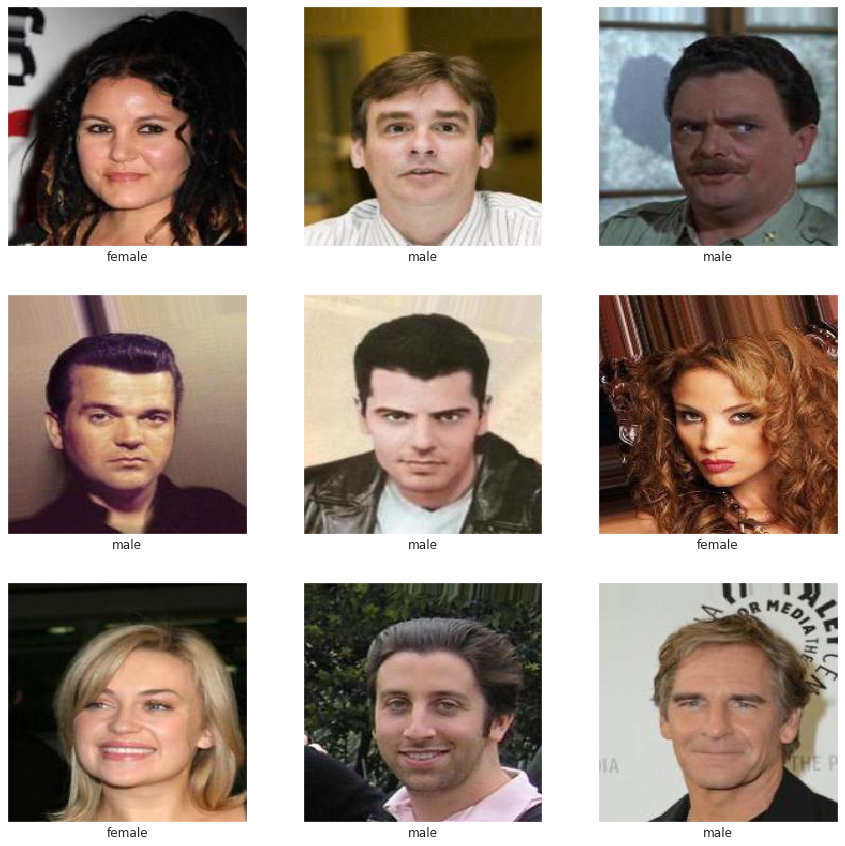

In [3]:
part = partition['train']
id = np.random.choice(list(range(len(part['img']))), 9, False)
decode = {0: 'male', 1: 'female'}

fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  # print(label)
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  ax.imshow(img)
  ax.set_xlabel(f'{gender}')

  # Remove ticks from the plot.
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

Como se puede observar en la imagen anterior, el ojo de la izquierda (el ojo
derecho de la persona), siempre esta en el mismo lugar con sutiles diferencias,
por lo que se propone incrustar a la imagen una mascarilla, con diferentes
formas y texturas.

Se tienen 2 tipos de mascarillas de las cuales se elegiran aleatoriamente
durante el entrenamiento.

De demostracion se mostraran los 2 tipos de mascarillas

**Mascarilla tipo forma**:

  Este tipo de mascarilla se obtiene de una imagen de una persona con la
  mascarilla puesta, se extrae la mascarilla unicamente y se genera la imagen
  con la mascarilla ubicada tal que tape la nariz y la boca de la persona.

  De este tipo de mascarilla se tienen 68 imagenes

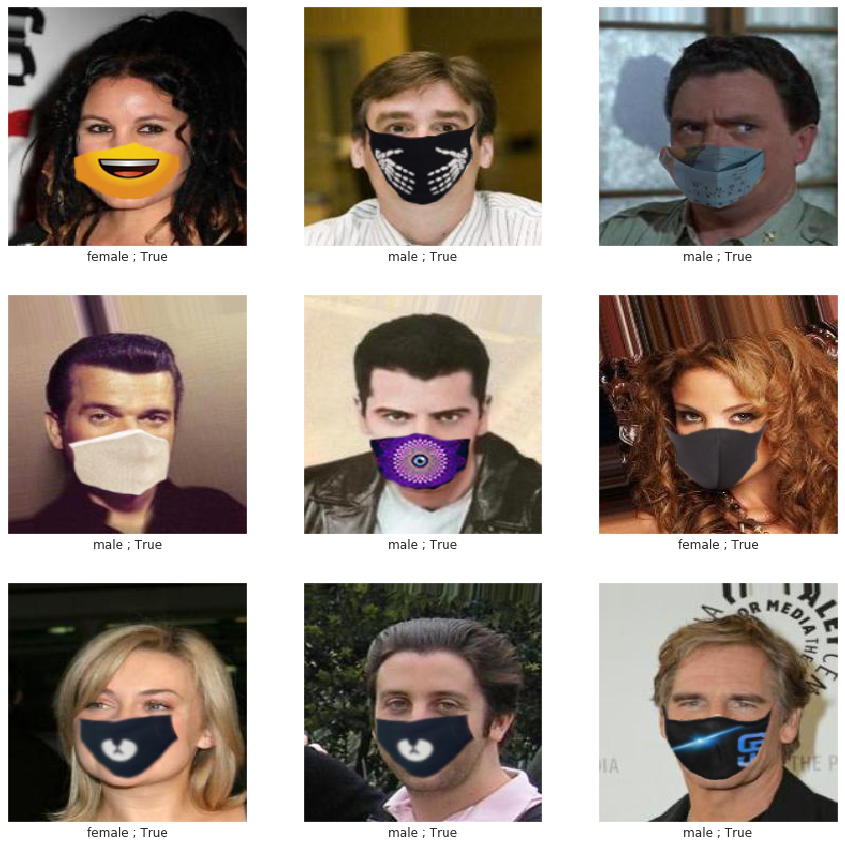

In [4]:
fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  mask = True

  img_mask = io.imread(np.random.choice(masks))

  img = np.uint8(img * (1 - img_mask[:,:,-1:]/255) + img_mask[:,:,:3] * (img_mask[:,:,-1:]/255))

  ax.imshow(img)
  ax.set_xlabel(f'{gender} ; {mask}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

**Mascarilla tipo textura**:

  Este tipo de mascarilla utiliza la forma de la mascarilla anterior, con la
  diferencia de que el color y la textura se reemplaza por otra extraida
  desde https://www.textures.com Esta pagina tiene diferentes tipos de texturas
  se utilizan 510 texturas diferentes, y de esta manera se pueden lograr
  generar mas de 34680 mascarillas dis
  tintas.

  Con data augmentation, de flip para arriba (50%) y a los lados (50%), mas un
  corte aleatorio de la imagen (las texturas tienen un tamaño superior a la
  base de datos) es posible mutiplicar el valor anterior por 100 o mas,
  dependiendo del corte donde se realice

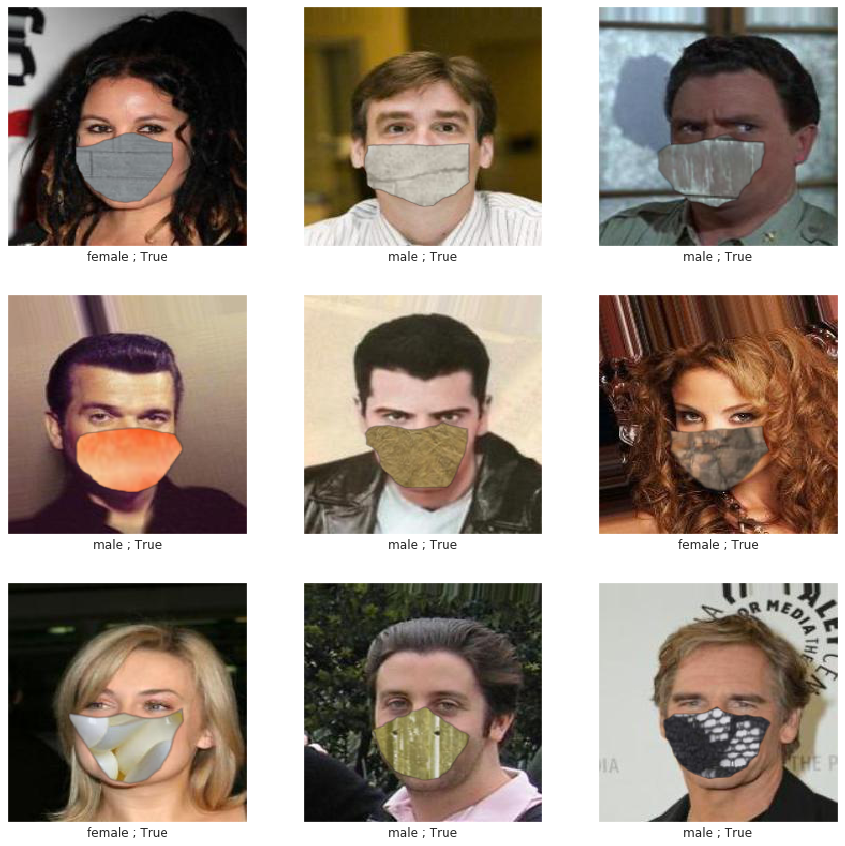

In [5]:
# data augmentation for textures
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq_texture = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.CropToFixedSize(width=224, height=224),
    ]
  )

fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  mask = True

  im_tex = io.imread(np.random.choice(texture))
  im_tex = seq_texture(image=im_tex)
  im_tex = resize(im_tex, [224,224]) * 255
  im_form = io.imread(np.random.choice(masks))

  img_mask = np.zeros_like(im_form)
  img_mask_wo_transparency = (np.float32(im_form[:,:, -1:]) / 255) * np.float32(im_tex)
  img_mask[:,:,:3] = img_mask_wo_transparency
  img_mask[...,-1] = im_form[..., -1]

  img = np.uint8(img * (1 - img_mask[:,:,-1:]/255) + img_mask[:,:,:3] * (img_mask[:,:,-1:]/255))

  ax.imshow(img)
  ax.set_xlabel(f'{gender} ; {mask}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

Juntando todo lo anterior:

  La base de datos tendra un 50% de probabilida de tener mascarilla

  Si tiene mascarilla:
    Tendra un 50% de probabilidad de escoger entre mascarilla de tipo textura
    o de tipo forma

A continuacion se muestran las imagenes finales con las que sera entrenada la
red neuronal, adicionando el data augmentation a la imagen final

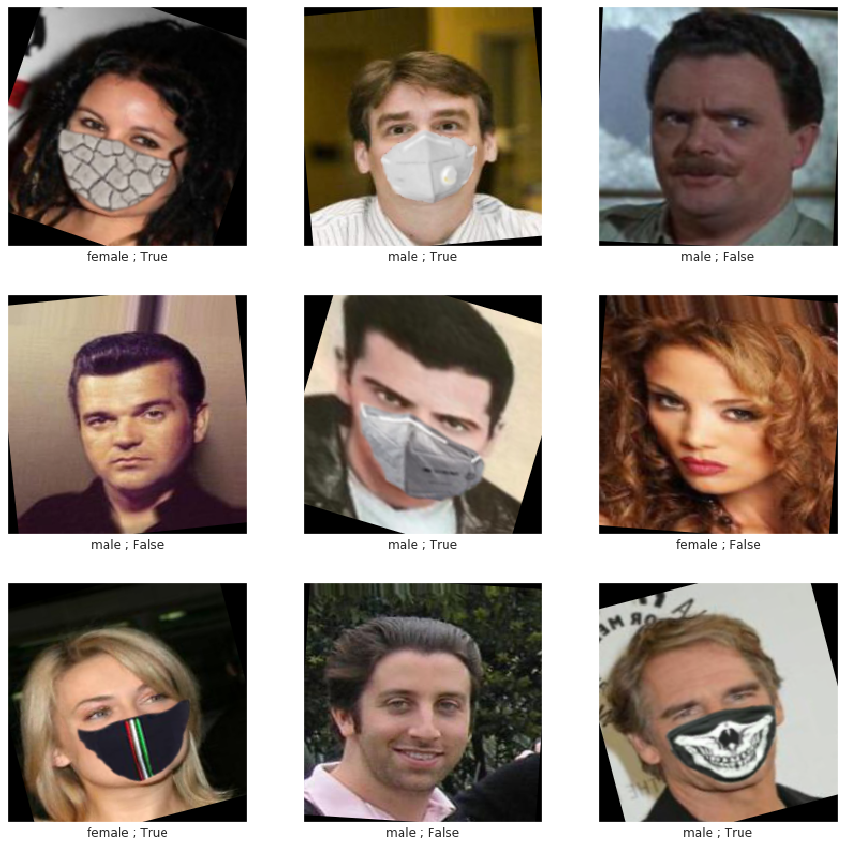

In [6]:
seq_imgs = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Affine(rotate=(-20, 20)),
    ]
  )
fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  mask = False
  if np.random.randint(2):
    mask = True
    if np.random.randint(2):
      #texture
      im_tex = io.imread(np.random.choice(texture))
      im_tex = seq_texture(image=im_tex)
      im_tex = resize(im_tex, [224,224]) * 255
      im_form = io.imread(np.random.choice(masks))

      img_mask = np.zeros_like(im_form)
      img_mask_wo_transparency = (np.float32(im_form[:,:, -1:]) / 255) * np.float32(im_tex)
      img_mask[:,:,:3] = img_mask_wo_transparency
      img_mask[...,-1] = im_form[..., -1]

    else:
      img_mask = io.imread(np.random.choice(masks))

    img = img * (1 - img_mask[:,:,-1:]/255) + img_mask[:,:,:3] * (img_mask[:,:,-1:]/255)

  img = np.uint8(img)
  img = np.uint8(resize(img, (224, 224)) * 255)
  img = seq_imgs(image=img)

  ax.imshow(img)
  ax.set_xlabel(f'{gender} ; {mask}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Modelos
Se definen los 4 modelos:
  1. Modelo optimizado (Se considera optimizado con resultados sobre 90% de acc en validacion)
  2. Modelo VGG16
  3. Modelo MobileNet
  4. Modelo Resnet50

In [7]:
function_none = lambda x: x
function_one_hot = lambda x: to_categorical(x, 2)

def model_optimized():
  inputs = layers.Input((224, 224, 3))
  x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
  x = layers.Conv2D(32, (3, 3), padding='valid', use_bias=False, strides=(2, 2), name='conv1')(x)
  x = layers.BatchNormalization(name='conv1_bn')(x)
  x = layers.ReLU(10., name='conv1_relu')(x)

  id = 0
  id += 1
  x = layers.SeparableConv2D(64, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(128, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(128, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(256, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(256, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)


  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  mask = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(mask)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(1024, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(1024, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  gender = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  mask = layers.GlobalAvgPool2D()(mask)
  gender = layers.GlobalAvgPool2D()(gender)

  mask = layers.Dropout(0.3)(mask)
  gender = layers.Dropout(0.3)(gender)

  mask = layers.Dense(1, activation='sigmoid', name='mask')(mask)
  gender = layers.Dense(1, activation='sigmoid', name='gender')(gender)

  model = Model(inputs=inputs, outputs=[gender, mask], name='optimized')

  model.compile('adam', {'gender': 'binary_crossentropy',
                         'mask': 'binary_crossentropy'},
                metrics=['acc'])

  return model, Optimized_preprocess, function_none

def model_VGG16():
  inputs = layers.Input((224, 224, 3))
  vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs, pooling='avg')
  vgg16.trainable = False

  x = layers.Dropout(0.3)(vgg16.outputs[0])
  x = layers.Dense(512, 'relu')(x)

  gender = layers.Dense(2, activation='softmax', name='gender')(x)
  mask = layers.Dense(2, activation='softmax', name='mask')(x)

  model = Model(inputs, outputs=[gender, mask], name='vgg10006')

  model.compile('adam', {'gender': 'categorical_crossentropy',
                         'mask': 'categorical_crossentropy'},
                metrics=['acc'])

  return model, VGG16_preprocess, function_one_hot

def model_MobileNet():
  inputs = layers.Input((224, 224, 3))
  mobilenet = MobileNet(include_top=False, weights="imagenet", input_tensor=inputs, pooling='avg')
  mobilenet.trainable = False

  x = layers.Dropout(0.3)(mobilenet.outputs[0])
  x = layers.Dense(1024, 'relu')(x)

  gender = layers.Dense(1, activation='sigmoid', name='gender')(x)
  mask = layers.Dense(1, activation='sigmoid', name='mask')(x)

  model = Model(inputs, outputs=[gender, mask], name='mobilenet')

  model.compile('adam', {'gender': 'mse',
                         'mask': 'mse'},
                metrics=['acc'])

  return model, MobileNet_preprocess, function_none

def model_ResNet():
  inputs = layers.Input((224, 224, 3))
  resnet = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs, pooling='avg')
  resnet.trainable = False

  x = layers.Dropout(0.3)(resnet.outputs[0])
  x = layers.Dense(1024, 'relu')(x)

  gender = layers.Dense(1, activation='sigmoid', name='gender')(x)
  mask = layers.Dense(1, activation='sigmoid', name='mask')(x)

  model = Model(inputs, outputs=[gender, mask], name='resnet')

  model.compile('adam', {'gender': 'binary_crossentropy',
                         'mask': 'binary_crossentropy'},
                metrics=['acc'])

  return model, ResNet_preprocess, function_none


models = {'vgg16': model_VGG16,
          'mobilenet': model_MobileNet,
          'resnet': model_ResNet,
          'optimized': model_optimized}

# Generators

Al ser un problema con muchos datos, y con la propuesta de generar imagenes en tiempo real, es necesario un generador que alimente a la red.

Este generador retorna imagenes cada vez que es llamada

In [8]:
# data augmentation
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq_texture = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.CropToFixedSize(width=224, height=224),
    ]
  )

seq_imgs = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Affine(rotate=(-20, 20)),
    ]
  )

class Generator(Sequence):
  def __init__(self, part, batchSize:int=4, data_set='train', preprocess=None,
               label_encoded=None):
    if data_set == 'train':
      assert label_encoded != None
      assert preprocess != None
    self.part = part
    self.part['img'] = np.array(part['img'])
    self.part['label'] = np.array(part['label'])
    self.data_set = data_set
    self.batch_size = batchSize

    self.on_epoch_end()

    self.label_encoded = label_encoded
    self.preprocess = preprocess

  def on_epoch_end(self):
    List = np.array(list(range(int(len(self.part['img'])))))
    np.random.shuffle(List)
    out_list = []
    l = []
    for lis in List:
      if len(l) == self.batch_size:
        out_list.append(l)
        l = []
      l.append(lis)
    if len(l) > 0:
      out_list.append(l)
    self.list = np.array(out_list)

  def __len__(self):
    return len(self.list)

  def __getitem__(self, index):
    id = self.list[index]

    imgs = []
    labels = {'gender': [], 'mask': []}
    # labels = []
    for path, label in zip(self.part['img'][id], self.part['label'][id]):
      # print(label)
      gender = int(label == 'Female')

      img = io.imread(path)

      mask = 0
      if np.random.randint(2):
        mask = 1
        if np.random.randint(2):
          #texture
          im_tex = io.imread(np.random.choice(texture))
          im_tex = seq_texture(image=im_tex)
          im_tex = resize(im_tex, [224,224]) * 255
          im_form = io.imread(np.random.choice(masks))

          img_mask = np.zeros_like(im_form)
          img_mask_wo_transparency = (np.float32(im_form[..., -1:]) / 255) * np.float32(im_tex)
          img_mask[:,:,:3] = img_mask_wo_transparency
          img_mask[...,-1] = im_form[..., -1]

        else:
          img_mask = io.imread(np.random.choice(masks))

        img = img * (1 - img_mask[:,:,-1:]/255) + img_mask[...,:3] * (img_mask[:,:,-1:]/255)

      img = np.uint8(img)
      img = np.uint8(resize(img, (224, 224)) * 255)
      imgs.append(img)
      labels['gender'].append(gender)
      labels['mask'].append(mask)
    imgs = np.array(imgs)
    if self.data_set == 'train':
      imgs = seq_imgs(images=imgs)
    labels['gender'] = np.array(labels['gender'])
    labels['mask'] = np.array(labels['mask'])
    if self.data_set == 'train':
      imgs = self.preprocess(imgs)
      labels['gender'] = self.label_encoded(labels['gender'])
      labels['mask']   = self.label_encoded(labels['mask'])
    return imgs, labels

# Funciones 
Estas funciones ayudan a que el codigo se vea mas organizado

In [9]:
def plot_history(history, title):

    losses = list(np.copy(history.history['loss']))
    # accs = list(np.copy(history.history['acc']))
    hue = ['train'] * len(history.history['loss'])

    losses.extend(history.history['val_loss'])
    # accs.extend(history.history['val_acc'])
    hue.extend(['val'] * len(history.history['val_loss']))

    epoch = list(np.copy(history.epoch))
    epoch.extend(history.epoch)

    to_plot = pd.DataFrame(dict(
    epochs=epoch,
    losses=losses,
    dataset=hue,
    ))

    losses = list(np.copy(history.history['gender_loss']))
    hue = ['gender train loss'] * len(history.history['loss'])
    epoch = list(np.copy(history.epoch))

    losses.extend(list(np.copy(history.history['mask_loss'])))
    hue.extend(['mask train  loss'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    losses.extend(list(np.copy(history.history['val_gender_loss'])))
    hue.extend(['gender val  loss'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    losses.extend(list(np.copy(history.history['val_mask_loss'])))
    hue.extend(['mask val  loss'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    to_plot_loss_class = pd.DataFrame(dict(
    epochs=epoch,
    losses=losses,
    dataset=hue
    ))

    acc = list(np.copy(history.history['gender_acc']))
    hue = ['gender train acc'] * len(history.history['loss'])
    epoch = list(np.copy(history.epoch))

    acc.extend(list(np.copy(history.history['mask_acc'])))
    hue.extend(['mask train acc'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    acc.extend(list(np.copy(history.history['val_gender_acc'])))
    hue.extend(['gender val acc'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    acc.extend(list(np.copy(history.history['val_mask_acc'])))
    hue.extend(['mask val acc'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    to_plot_acc = pd.DataFrame(dict(
    epochs=epoch,
    accuracy=acc,
    dataset=hue
    ))

    ax = sns.relplot(x="epochs", y="losses", hue="dataset", kind="line",
                   ci="sd", data=to_plot)
    ax.set(title=title)
    plt.show()

    ax = sns.relplot(x="epochs", y="losses", hue="dataset", kind="line",
                   ci="sd", data=to_plot_loss_class)
    ax.set(title=title)
    plt.show()

    ax = sns.relplot(x="epochs", y="accuracy", hue="dataset", kind="line",
                   ci="sd", data=to_plot_acc)
    ax.set(title=title)
    plt.show()

# Entrenamiento de todas las redes

Se genera la validacion estatica, esta es creada una vez y es igual para todas las redes y entrenamientos

Luego se comienza a entrenar las redes y captura los resultados para mostrarlos despues

vgg16
Train for 625 steps, validate on 1000 samples
Epoch 1/20
624/625 [============================>.] - ETA: 0s - loss: 0.6581 - gender_loss: 0.5297 - mask_loss: 0.1284 - gender_acc: 0.8035 - mask_acc: 0.9622
Epoch 00001: val_loss improved from inf to 0.50034, saving model to ./models/model_vgg16_E20_B16.h5
625/625 [==============================] - 128s 205ms/step - loss: 0.6582 - gender_loss: 0.5298 - mask_loss: 0.1284 - gender_acc: 0.8032 - mask_acc: 0.9622 - val_loss: 0.5003 - val_gender_loss: 0.3433 - val_mask_loss: 0.1560 - val_gender_acc: 0.8610 - val_mask_acc: 0.9520
Epoch 2/20
624/625 [============================>.] - ETA: 0s - loss: 0.4322 - gender_loss: 0.3661 - mask_loss: 0.0661 - gender_acc: 0.8398 - mask_acc: 0.9783
Epoch 00002: val_loss improved from 0.50034 to 0.48774, saving model to ./models/model_vgg16_E20_B16.h5
625/625 [==============================] - 119s 191ms/step - loss: 0.4324 - gender_loss: 0.3661 - mask_loss: 0.0662 - gender_acc: 0.8398 - mask_acc: 0.97

624/625 [============================>.] - ETA: 0s - loss: 0.3428 - gender_loss: 0.3079 - mask_loss: 0.0349 - gender_acc: 0.8683 - mask_acc: 0.9890
Epoch 00017: val_loss did not improve from 0.28641
625/625 [==============================] - 119s 190ms/step - loss: 0.3435 - gender_loss: 0.3081 - mask_loss: 0.0354 - gender_acc: 0.8680 - mask_acc: 0.9889 - val_loss: 0.3191 - val_gender_loss: 0.2681 - val_mask_loss: 0.0509 - val_gender_acc: 0.8920 - val_mask_acc: 0.9810
Epoch 18/20
624/625 [============================>.] - ETA: 0s - loss: 0.3342 - gender_loss: 0.2981 - mask_loss: 0.0361 - gender_acc: 0.8715 - mask_acc: 0.9877
Epoch 00018: val_loss did not improve from 0.28641
625/625 [==============================] - 117s 188ms/step - loss: 0.3343 - gender_loss: 0.2982 - mask_loss: 0.0361 - gender_acc: 0.8714 - mask_acc: 0.9877 - val_loss: 0.3075 - val_gender_loss: 0.2686 - val_mask_loss: 0.0381 - val_gender_acc: 0.8890 - val_mask_acc: 0.9840
Epoch 19/20
624/625 [=======================

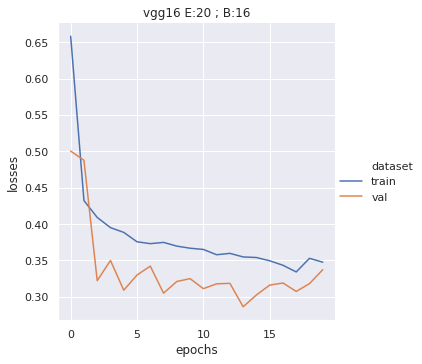

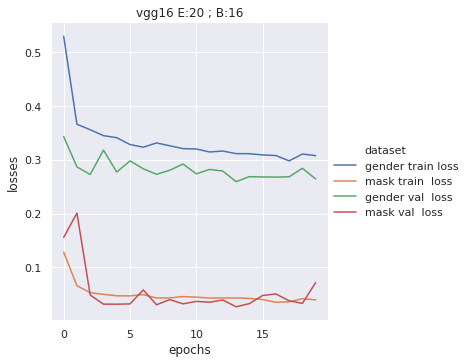

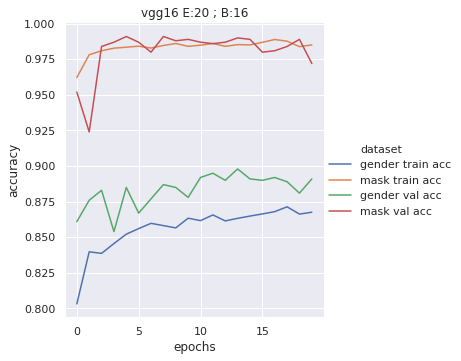

Train for 625 steps, validate on 1000 samples
Epoch 1/60
624/625 [============================>.] - ETA: 0s - loss: 0.6488 - gender_loss: 0.5280 - mask_loss: 0.1208 - gender_acc: 0.8027 - mask_acc: 0.9618
Epoch 00001: val_loss improved from inf to 0.38414, saving model to ./models/model_vgg16_E60_B16.h5
625/625 [==============================] - 118s 188ms/step - loss: 0.6484 - gender_loss: 0.5277 - mask_loss: 0.1207 - gender_acc: 0.8028 - mask_acc: 0.9619 - val_loss: 0.3841 - val_gender_loss: 0.3179 - val_mask_loss: 0.0674 - val_gender_acc: 0.8620 - val_mask_acc: 0.9810
Epoch 2/60
624/625 [============================>.] - ETA: 0s - loss: 0.4220 - gender_loss: 0.3611 - mask_loss: 0.0609 - gender_acc: 0.8468 - mask_acc: 0.9800
Epoch 00002: val_loss improved from 0.38414 to 0.36653, saving model to ./models/model_vgg16_E60_B16.h5
625/625 [==============================] - 118s 188ms/step - loss: 0.4215 - gender_loss: 0.3607 - mask_loss: 0.0608 - gender_acc: 0.8470 - mask_acc: 0.9800 - v

Epoch 34/60
624/625 [============================>.] - ETA: 0s - loss: 0.3304 - gender_loss: 0.2976 - mask_loss: 0.0328 - gender_acc: 0.8719 - mask_acc: 0.9876
Epoch 00034: val_loss did not improve from 0.29259
625/625 [==============================] - 119s 191ms/step - loss: 0.3307 - gender_loss: 0.2975 - mask_loss: 0.0332 - gender_acc: 0.8720 - mask_acc: 0.9875 - val_loss: 0.3226 - val_gender_loss: 0.2740 - val_mask_loss: 0.0477 - val_gender_acc: 0.8920 - val_mask_acc: 0.9820
Epoch 35/60
624/625 [============================>.] - ETA: 0s - loss: 0.3326 - gender_loss: 0.2981 - mask_loss: 0.0345 - gender_acc: 0.8685 - mask_acc: 0.9876
Epoch 00035: val_loss did not improve from 0.29259
625/625 [==============================] - 120s 192ms/step - loss: 0.3322 - gender_loss: 0.2977 - mask_loss: 0.0345 - gender_acc: 0.8687 - mask_acc: 0.9876 - val_loss: 0.3226 - val_gender_loss: 0.2848 - val_mask_loss: 0.0367 - val_gender_acc: 0.8710 - val_mask_acc: 0.9880
Epoch 36/60
624/625 [===========

Epoch 51/60
624/625 [============================>.] - ETA: 0s - loss: 0.3106 - gender_loss: 0.2817 - mask_loss: 0.0289 - gender_acc: 0.8779 - mask_acc: 0.9890
Epoch 00051: val_loss improved from 0.29259 to 0.28855, saving model to ./models/model_vgg16_E60_B16.h5
625/625 [==============================] - 118s 189ms/step - loss: 0.3104 - gender_loss: 0.2815 - mask_loss: 0.0290 - gender_acc: 0.8781 - mask_acc: 0.9889 - val_loss: 0.2885 - val_gender_loss: 0.2563 - val_mask_loss: 0.0316 - val_gender_acc: 0.8940 - val_mask_acc: 0.9890
Epoch 52/60
624/625 [============================>.] - ETA: 0s - loss: 0.3049 - gender_loss: 0.2731 - mask_loss: 0.0318 - gender_acc: 0.8837 - mask_acc: 0.9895
Epoch 00052: val_loss did not improve from 0.28855
625/625 [==============================] - 117s 187ms/step - loss: 0.3047 - gender_loss: 0.2729 - mask_loss: 0.0318 - gender_acc: 0.8838 - mask_acc: 0.9895 - val_loss: 0.3236 - val_gender_loss: 0.2684 - val_mask_loss: 0.0537 - val_gender_acc: 0.8770 - 

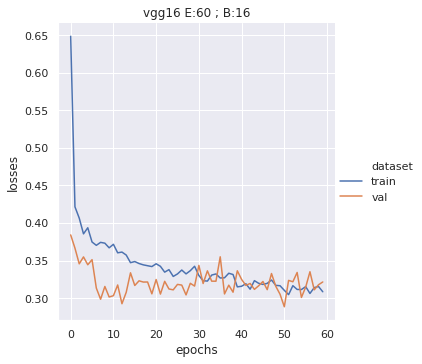

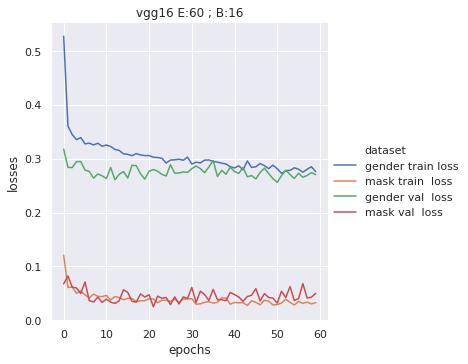

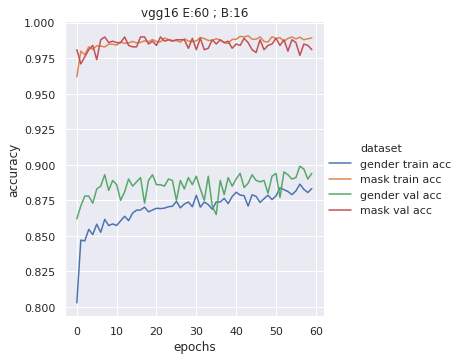

Train for 625 steps, validate on 1000 samples
Epoch 1/200
624/625 [============================>.] - ETA: 0s - loss: 0.6722 - gender_loss: 0.5439 - mask_loss: 0.1283 - gender_acc: 0.8058 - mask_acc: 0.9606
Epoch 00001: val_loss improved from inf to 0.36848, saving model to ./models/model_vgg16_E200_B16.h5
625/625 [==============================] - 118s 190ms/step - loss: 0.6716 - gender_loss: 0.5436 - mask_loss: 0.1281 - gender_acc: 0.8060 - mask_acc: 0.9607 - val_loss: 0.3685 - val_gender_loss: 0.2974 - val_mask_loss: 0.0700 - val_gender_acc: 0.8700 - val_mask_acc: 0.9770
Epoch 2/200
624/625 [============================>.] - ETA: 0s - loss: 0.4187 - gender_loss: 0.3577 - mask_loss: 0.0609 - gender_acc: 0.8411 - mask_acc: 0.9796
Epoch 00002: val_loss did not improve from 0.36848
625/625 [==============================] - 117s 188ms/step - loss: 0.4184 - gender_loss: 0.3575 - mask_loss: 0.0609 - gender_acc: 0.8413 - mask_acc: 0.9796 - val_loss: 0.4093 - val_gender_loss: 0.3290 - val_ma

Epoch 34/200
624/625 [============================>.] - ETA: 0s - loss: 0.3308 - gender_loss: 0.2958 - mask_loss: 0.0350 - gender_acc: 0.8702 - mask_acc: 0.9877
Epoch 00034: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 188ms/step - loss: 0.3307 - gender_loss: 0.2957 - mask_loss: 0.0350 - gender_acc: 0.8702 - mask_acc: 0.9877 - val_loss: 0.2978 - val_gender_loss: 0.2699 - val_mask_loss: 0.0276 - val_gender_acc: 0.8960 - val_mask_acc: 0.9900
Epoch 35/200
624/625 [============================>.] - ETA: 0s - loss: 0.3264 - gender_loss: 0.2929 - mask_loss: 0.0335 - gender_acc: 0.8769 - mask_acc: 0.9879
Epoch 00035: val_loss did not improve from 0.28884
625/625 [==============================] - 118s 188ms/step - loss: 0.3265 - gender_loss: 0.2930 - mask_loss: 0.0336 - gender_acc: 0.8768 - mask_acc: 0.9878 - val_loss: 0.3232 - val_gender_loss: 0.2705 - val_mask_loss: 0.0513 - val_gender_acc: 0.8910 - val_mask_acc: 0.9830
Epoch 36/200
624/625 [========

Epoch 51/200
624/625 [============================>.] - ETA: 0s - loss: 0.3126 - gender_loss: 0.2801 - mask_loss: 0.0325 - gender_acc: 0.8777 - mask_acc: 0.9885
Epoch 00051: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.3127 - gender_loss: 0.2802 - mask_loss: 0.0325 - gender_acc: 0.8777 - mask_acc: 0.9885 - val_loss: 0.2999 - val_gender_loss: 0.2695 - val_mask_loss: 0.0294 - val_gender_acc: 0.8890 - val_mask_acc: 0.9870
Epoch 52/200
624/625 [============================>.] - ETA: 0s - loss: 0.3167 - gender_loss: 0.2812 - mask_loss: 0.0355 - gender_acc: 0.8786 - mask_acc: 0.9874
Epoch 00052: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.3167 - gender_loss: 0.2812 - mask_loss: 0.0355 - gender_acc: 0.8785 - mask_acc: 0.9874 - val_loss: 0.2973 - val_gender_loss: 0.2599 - val_mask_loss: 0.0369 - val_gender_acc: 0.8930 - val_mask_acc: 0.9870
Epoch 53/200
624/625 [========

Epoch 68/200
624/625 [============================>.] - ETA: 0s - loss: 0.3102 - gender_loss: 0.2789 - mask_loss: 0.0313 - gender_acc: 0.8812 - mask_acc: 0.9899
Epoch 00068: val_loss did not improve from 0.28884
625/625 [==============================] - 118s 189ms/step - loss: 0.3104 - gender_loss: 0.2787 - mask_loss: 0.0316 - gender_acc: 0.8813 - mask_acc: 0.9898 - val_loss: 0.3186 - val_gender_loss: 0.2717 - val_mask_loss: 0.0459 - val_gender_acc: 0.8910 - val_mask_acc: 0.9860
Epoch 69/200
624/625 [============================>.] - ETA: 0s - loss: 0.3016 - gender_loss: 0.2703 - mask_loss: 0.0313 - gender_acc: 0.8851 - mask_acc: 0.9900
Epoch 00069: val_loss did not improve from 0.28884
625/625 [==============================] - 118s 188ms/step - loss: 0.3018 - gender_loss: 0.2704 - mask_loss: 0.0314 - gender_acc: 0.8850 - mask_acc: 0.9899 - val_loss: 0.3604 - val_gender_loss: 0.2841 - val_mask_loss: 0.0754 - val_gender_acc: 0.8850 - val_mask_acc: 0.9770
Epoch 70/200
624/625 [========

Epoch 85/200
624/625 [============================>.] - ETA: 0s - loss: 0.2978 - gender_loss: 0.2700 - mask_loss: 0.0278 - gender_acc: 0.8886 - mask_acc: 0.9917
Epoch 00085: val_loss did not improve from 0.28884
625/625 [==============================] - 118s 188ms/step - loss: 0.2978 - gender_loss: 0.2700 - mask_loss: 0.0278 - gender_acc: 0.8887 - mask_acc: 0.9916 - val_loss: 0.3058 - val_gender_loss: 0.2669 - val_mask_loss: 0.0373 - val_gender_acc: 0.8890 - val_mask_acc: 0.9890
Epoch 86/200
624/625 [============================>.] - ETA: 0s - loss: 0.3012 - gender_loss: 0.2719 - mask_loss: 0.0293 - gender_acc: 0.8873 - mask_acc: 0.9907
Epoch 00086: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.3014 - gender_loss: 0.2721 - mask_loss: 0.0293 - gender_acc: 0.8872 - mask_acc: 0.9907 - val_loss: 0.3285 - val_gender_loss: 0.2825 - val_mask_loss: 0.0446 - val_gender_acc: 0.8860 - val_mask_acc: 0.9880
Epoch 87/200
624/625 [========

Epoch 102/200
624/625 [============================>.] - ETA: 0s - loss: 0.3001 - gender_loss: 0.2704 - mask_loss: 0.0297 - gender_acc: 0.8844 - mask_acc: 0.9895
Epoch 00102: val_loss did not improve from 0.28884
625/625 [==============================] - 118s 189ms/step - loss: 0.3000 - gender_loss: 0.2704 - mask_loss: 0.0297 - gender_acc: 0.8845 - mask_acc: 0.9895 - val_loss: 0.3238 - val_gender_loss: 0.2794 - val_mask_loss: 0.0429 - val_gender_acc: 0.8890 - val_mask_acc: 0.9880
Epoch 103/200
624/625 [============================>.] - ETA: 0s - loss: 0.3017 - gender_loss: 0.2739 - mask_loss: 0.0278 - gender_acc: 0.8837 - mask_acc: 0.9912
Epoch 00103: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.3020 - gender_loss: 0.2739 - mask_loss: 0.0281 - gender_acc: 0.8837 - mask_acc: 0.9911 - val_loss: 0.3217 - val_gender_loss: 0.2923 - val_mask_loss: 0.0278 - val_gender_acc: 0.8660 - val_mask_acc: 0.9930
Epoch 104/200
624/625 [=====

Epoch 119/200
624/625 [============================>.] - ETA: 0s - loss: 0.2930 - gender_loss: 0.2609 - mask_loss: 0.0320 - gender_acc: 0.8922 - mask_acc: 0.9903
Epoch 00119: val_loss did not improve from 0.28884
625/625 [==============================] - 116s 185ms/step - loss: 0.2931 - gender_loss: 0.2608 - mask_loss: 0.0323 - gender_acc: 0.8923 - mask_acc: 0.9902 - val_loss: 0.3027 - val_gender_loss: 0.2640 - val_mask_loss: 0.0376 - val_gender_acc: 0.9020 - val_mask_acc: 0.9890
Epoch 120/200
624/625 [============================>.] - ETA: 0s - loss: 0.2918 - gender_loss: 0.2625 - mask_loss: 0.0293 - gender_acc: 0.8915 - mask_acc: 0.9900
Epoch 00120: val_loss did not improve from 0.28884
625/625 [==============================] - 115s 184ms/step - loss: 0.2917 - gender_loss: 0.2624 - mask_loss: 0.0293 - gender_acc: 0.8915 - mask_acc: 0.9900 - val_loss: 0.3098 - val_gender_loss: 0.2776 - val_mask_loss: 0.0310 - val_gender_acc: 0.8800 - val_mask_acc: 0.9910
Epoch 121/200
624/625 [=====

Epoch 136/200
624/625 [============================>.] - ETA: 0s - loss: 0.2936 - gender_loss: 0.2668 - mask_loss: 0.0268 - gender_acc: 0.8877 - mask_acc: 0.9905
Epoch 00136: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.2935 - gender_loss: 0.2666 - mask_loss: 0.0269 - gender_acc: 0.8878 - mask_acc: 0.9905 - val_loss: 0.3439 - val_gender_loss: 0.2773 - val_mask_loss: 0.0658 - val_gender_acc: 0.8870 - val_mask_acc: 0.9800
Epoch 137/200
624/625 [============================>.] - ETA: 0s - loss: 0.2879 - gender_loss: 0.2604 - mask_loss: 0.0275 - gender_acc: 0.8915 - mask_acc: 0.9906
Epoch 00137: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 188ms/step - loss: 0.2878 - gender_loss: 0.2603 - mask_loss: 0.0275 - gender_acc: 0.8916 - mask_acc: 0.9906 - val_loss: 0.3472 - val_gender_loss: 0.2912 - val_mask_loss: 0.0541 - val_gender_acc: 0.8850 - val_mask_acc: 0.9860
Epoch 138/200
624/625 [=====

Epoch 153/200
624/625 [============================>.] - ETA: 0s - loss: 0.2845 - gender_loss: 0.2563 - mask_loss: 0.0282 - gender_acc: 0.8930 - mask_acc: 0.9918
Epoch 00153: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.2846 - gender_loss: 0.2565 - mask_loss: 0.0282 - gender_acc: 0.8930 - mask_acc: 0.9918 - val_loss: 0.3277 - val_gender_loss: 0.2843 - val_mask_loss: 0.0420 - val_gender_acc: 0.8690 - val_mask_acc: 0.9910
Epoch 154/200
624/625 [============================>.] - ETA: 0s - loss: 0.2831 - gender_loss: 0.2553 - mask_loss: 0.0278 - gender_acc: 0.8947 - mask_acc: 0.9905
Epoch 00154: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.2832 - gender_loss: 0.2551 - mask_loss: 0.0280 - gender_acc: 0.8948 - mask_acc: 0.9904 - val_loss: 0.3248 - val_gender_loss: 0.2835 - val_mask_loss: 0.0405 - val_gender_acc: 0.8790 - val_mask_acc: 0.9870
Epoch 155/200
624/625 [=====

Epoch 170/200
624/625 [============================>.] - ETA: 0s - loss: 0.2902 - gender_loss: 0.2607 - mask_loss: 0.0295 - gender_acc: 0.8905 - mask_acc: 0.9912
Epoch 00170: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.2907 - gender_loss: 0.2606 - mask_loss: 0.0301 - gender_acc: 0.8905 - mask_acc: 0.9911 - val_loss: 0.3302 - val_gender_loss: 0.2927 - val_mask_loss: 0.0362 - val_gender_acc: 0.8870 - val_mask_acc: 0.9900
Epoch 171/200
624/625 [============================>.] - ETA: 0s - loss: 0.2831 - gender_loss: 0.2541 - mask_loss: 0.0290 - gender_acc: 0.8963 - mask_acc: 0.9904
Epoch 00171: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 188ms/step - loss: 0.2831 - gender_loss: 0.2540 - mask_loss: 0.0291 - gender_acc: 0.8963 - mask_acc: 0.9903 - val_loss: 0.3389 - val_gender_loss: 0.2955 - val_mask_loss: 0.0419 - val_gender_acc: 0.8730 - val_mask_acc: 0.9920
Epoch 172/200
624/625 [=====

Epoch 187/200
624/625 [============================>.] - ETA: 0s - loss: 0.2739 - gender_loss: 0.2481 - mask_loss: 0.0258 - gender_acc: 0.8966 - mask_acc: 0.9909
Epoch 00187: val_loss did not improve from 0.28884
625/625 [==============================] - 117s 187ms/step - loss: 0.2740 - gender_loss: 0.2482 - mask_loss: 0.0258 - gender_acc: 0.8966 - mask_acc: 0.9909 - val_loss: 0.3226 - val_gender_loss: 0.2842 - val_mask_loss: 0.0372 - val_gender_acc: 0.8800 - val_mask_acc: 0.9930
Epoch 188/200
624/625 [============================>.] - ETA: 0s - loss: 0.2761 - gender_loss: 0.2453 - mask_loss: 0.0307 - gender_acc: 0.8938 - mask_acc: 0.9906
Epoch 00188: val_loss did not improve from 0.28884
625/625 [==============================] - 116s 186ms/step - loss: 0.2759 - gender_loss: 0.2453 - mask_loss: 0.0307 - gender_acc: 0.8938 - mask_acc: 0.9906 - val_loss: 0.3278 - val_gender_loss: 0.2792 - val_mask_loss: 0.0470 - val_gender_acc: 0.8910 - val_mask_acc: 0.9870
Epoch 189/200
624/625 [=====

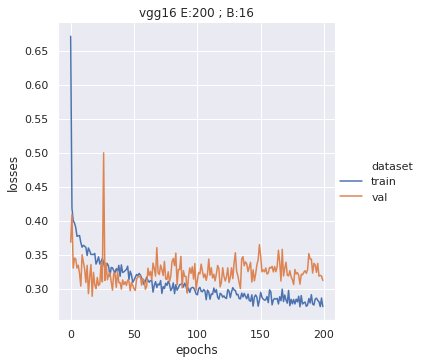

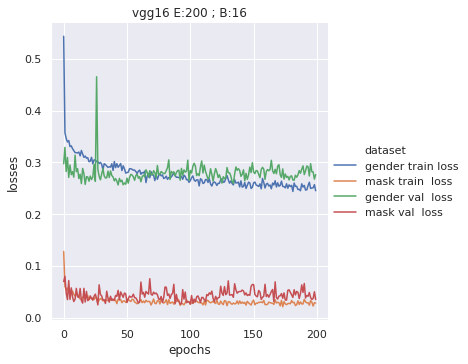

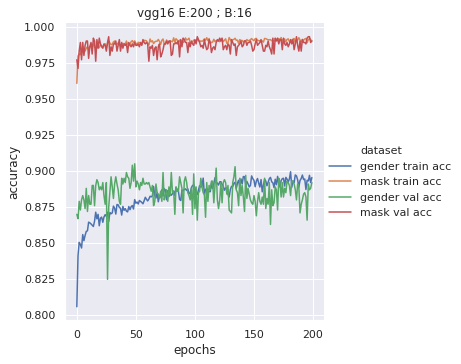

mobilenet


/home/mvaldi/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train for 625 steps, validate on 1000 samples
Epoch 1/20
624/625 [============================>.] - ETA: 0s - loss: 1.0038 - gender_loss: 0.5001 - mask_loss: 0.5037 - gender_acc: 0.4994 - mask_acc: 0.4955
Epoch 00001: val_loss improved from inf to 1.02100, saving model to ./models/model_mobilenet_E20_B16.h5
625/625 [==============================] - 111s 178ms/step - loss: 1.0035 - gender_loss: 0.5000 - mask_loss: 0.5035 - gender_acc: 0.4995 - mask_acc: 0.4957 - val_loss: 1.0210 - val_gender_loss: 0.5000 - val_mask_loss: 0.5218 - val_gender_acc: 0.5000 - val_mask_acc: 0.4790
Epoch 2/20
624/625 [============================>.] - ETA: 0s - loss: 1.0075 - gender_loss: 0.5001 - mask_loss: 0.5074 - gender_acc: 0.4999 - mask_acc: 0.4926
Epoch 00002: val_loss did not improve from 1.02100
625/625 [==============================] - 110s 177ms/step - loss: 1.0078 - gender_loss: 0.5000 - mask_loss: 0.5078 - gender_acc: 0.5000 - mask_acc: 0.4922 - val_loss: 1.0210 - val_gender_loss: 0.5000 - val_m

Epoch 18/20
624/625 [============================>.] - ETA: 0s - loss: 1.0019 - gender_loss: 0.5001 - mask_loss: 0.5018 - gender_acc: 0.4999 - mask_acc: 0.4982
Epoch 00018: val_loss did not improve from 1.02100
625/625 [==============================] - 110s 177ms/step - loss: 1.0018 - gender_loss: 0.5000 - mask_loss: 0.5018 - gender_acc: 0.5000 - mask_acc: 0.4982 - val_loss: 1.0210 - val_gender_loss: 0.5000 - val_mask_loss: 0.5218 - val_gender_acc: 0.5000 - val_mask_acc: 0.4790
Epoch 19/20
624/625 [============================>.] - ETA: 0s - loss: 1.0039 - gender_loss: 0.5001 - mask_loss: 0.5038 - gender_acc: 0.4999 - mask_acc: 0.4962
Epoch 00019: val_loss did not improve from 1.02100
625/625 [==============================] - 110s 175ms/step - loss: 1.0039 - gender_loss: 0.5000 - mask_loss: 0.5039 - gender_acc: 0.5000 - mask_acc: 0.4961 - val_loss: 1.0210 - val_gender_loss: 0.5000 - val_mask_loss: 0.5218 - val_gender_acc: 0.5000 - val_mask_acc: 0.4790
Epoch 20/20
624/625 [===========

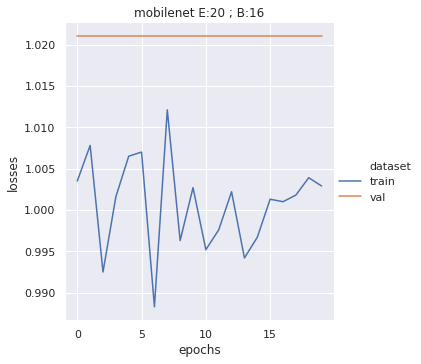

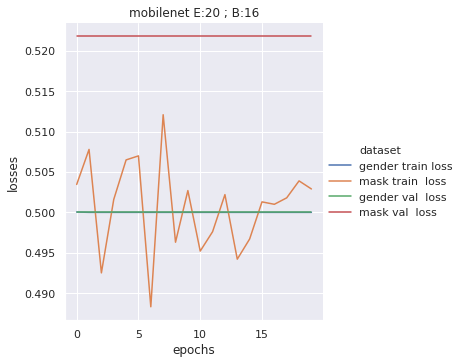

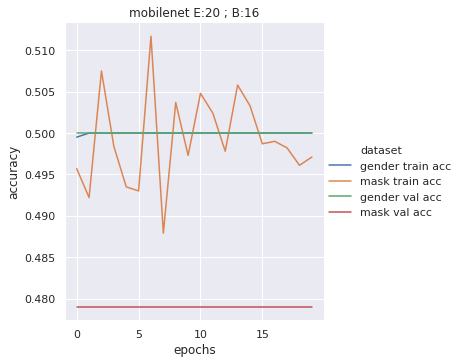

/home/mvaldi/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train for 625 steps, validate on 1000 samples
Epoch 1/60
624/625 [============================>.] - ETA: 0s - loss: 0.1987 - gender_loss: 0.1556 - mask_loss: 0.0431 - gender_acc: 0.7987 - mask_acc: 0.9467
Epoch 00001: val_loss improved from inf to 0.20343, saving model to ./models/model_mobilenet_E60_B16.h5
625/625 [==============================] - 111s 177ms/step - loss: 0.1987 - gender_loss: 0.1556 - mask_loss: 0.0432 - gender_acc: 0.7988 - mask_acc: 0.9466 - val_loss: 0.2034 - val_gender_loss: 0.1587 - val_mask_loss: 0.0457 - val_gender_acc: 0.7750 - val_mask_acc: 0.9460
Epoch 2/60
624/625 [============================>.] - ETA: 0s - loss: 0.1464 - gender_loss: 0.1164 - mask_loss: 0.0300 - gender_acc: 0.8334 - mask_acc: 0.9603
Epoch 00002: val_loss improved from 0.20343 to 0.16670, saving model to ./models/model_mobilenet_E60_B16.h5
625/625 [==============================] - 111s 177ms/step - loss: 0.1464 - gender_loss: 0.1164 - mask_loss: 0.0300 - gender_acc: 0.8335 - mask_acc: 0.

Epoch 34/60
624/625 [============================>.] - ETA: 0s - loss: 0.1033 - gender_loss: 0.0859 - mask_loss: 0.0174 - gender_acc: 0.8834 - mask_acc: 0.9765
Epoch 00034: val_loss did not improve from 0.09486
625/625 [==============================] - 112s 180ms/step - loss: 0.1033 - gender_loss: 0.0858 - mask_loss: 0.0174 - gender_acc: 0.8835 - mask_acc: 0.9765 - val_loss: 0.1115 - val_gender_loss: 0.0966 - val_mask_loss: 0.0153 - val_gender_acc: 0.8750 - val_mask_acc: 0.9830
Epoch 35/60
624/625 [============================>.] - ETA: 0s - loss: 0.0999 - gender_loss: 0.0829 - mask_loss: 0.0169 - gender_acc: 0.8870 - mask_acc: 0.9780
Epoch 00035: val_loss did not improve from 0.09486
625/625 [==============================] - 112s 179ms/step - loss: 0.0998 - gender_loss: 0.0829 - mask_loss: 0.0169 - gender_acc: 0.8871 - mask_acc: 0.9780 - val_loss: 0.1138 - val_gender_loss: 0.0976 - val_mask_loss: 0.0165 - val_gender_acc: 0.8800 - val_mask_acc: 0.9820
Epoch 36/60
624/625 [===========

Epoch 51/60
624/625 [============================>.] - ETA: 0s - loss: 0.0973 - gender_loss: 0.0819 - mask_loss: 0.0154 - gender_acc: 0.8874 - mask_acc: 0.9808
Epoch 00051: val_loss did not improve from 0.09486
625/625 [==============================] - 118s 189ms/step - loss: 0.0975 - gender_loss: 0.0820 - mask_loss: 0.0156 - gender_acc: 0.8873 - mask_acc: 0.9806 - val_loss: 0.1244 - val_gender_loss: 0.1128 - val_mask_loss: 0.0124 - val_gender_acc: 0.8590 - val_mask_acc: 0.9860
Epoch 52/60
624/625 [============================>.] - ETA: 0s - loss: 0.1001 - gender_loss: 0.0839 - mask_loss: 0.0161 - gender_acc: 0.8849 - mask_acc: 0.9802
Epoch 00052: val_loss did not improve from 0.09486
625/625 [==============================] - 117s 187ms/step - loss: 0.1001 - gender_loss: 0.0839 - mask_loss: 0.0162 - gender_acc: 0.8849 - mask_acc: 0.9801 - val_loss: 0.1281 - val_gender_loss: 0.1139 - val_mask_loss: 0.0149 - val_gender_acc: 0.8520 - val_mask_acc: 0.9850
Epoch 53/60
624/625 [===========

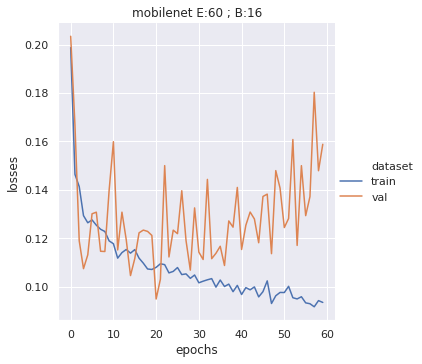

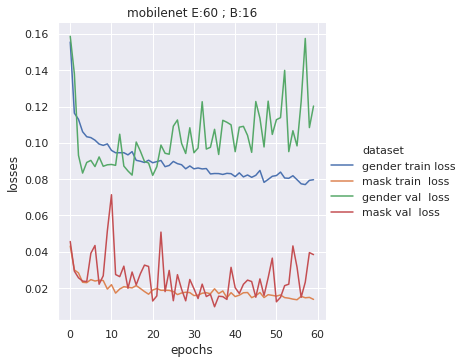

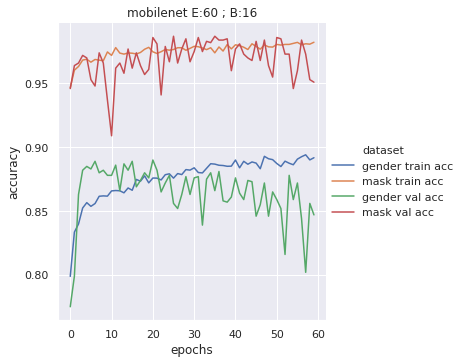

/home/mvaldi/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train for 625 steps, validate on 1000 samples
Epoch 1/200
624/625 [============================>.] - ETA: 0s - loss: 0.2648 - gender_loss: 0.2180 - mask_loss: 0.0468 - gender_acc: 0.7526 - mask_acc: 0.9399
Epoch 00001: val_loss improved from inf to 0.22385, saving model to ./models/model_mobilenet_E200_B16.h5
625/625 [==============================] - 118s 189ms/step - loss: 0.2646 - gender_loss: 0.2178 - mask_loss: 0.0468 - gender_acc: 0.7527 - mask_acc: 0.9399 - val_loss: 0.2238 - val_gender_loss: 0.1359 - val_mask_loss: 0.0877 - val_gender_acc: 0.8180 - val_mask_acc: 0.8870
Epoch 2/200
624/625 [============================>.] - ETA: 0s - loss: 0.1556 - gender_loss: 0.1270 - mask_loss: 0.0287 - gender_acc: 0.8262 - mask_acc: 0.9626
Epoch 00002: val_loss improved from 0.22385 to 0.19454, saving model to ./models/model_mobilenet_E200_B16.h5
625/625 [==============================] - 120s 191ms/step - loss: 0.1558 - gender_loss: 0.1270 - mask_loss: 0.0287 - gender_acc: 0.8260 - mask_acc

Epoch 17/200
624/625 [============================>.] - ETA: 0s - loss: 0.1122 - gender_loss: 0.0933 - mask_loss: 0.0189 - gender_acc: 0.8704 - mask_acc: 0.9742
Epoch 00017: val_loss did not improve from 0.10670
625/625 [==============================] - 129s 207ms/step - loss: 0.1122 - gender_loss: 0.0934 - mask_loss: 0.0189 - gender_acc: 0.8703 - mask_acc: 0.9742 - val_loss: 0.1149 - val_gender_loss: 0.0897 - val_mask_loss: 0.0255 - val_gender_acc: 0.8790 - val_mask_acc: 0.9700
Epoch 18/200
624/625 [============================>.] - ETA: 0s - loss: 0.1143 - gender_loss: 0.0942 - mask_loss: 0.0200 - gender_acc: 0.8687 - mask_acc: 0.9733
Epoch 00018: val_loss improved from 0.10670 to 0.10609, saving model to ./models/model_mobilenet_E200_B16.h5
625/625 [==============================] - 116s 186ms/step - loss: 0.1143 - gender_loss: 0.0943 - mask_loss: 0.0200 - gender_acc: 0.8685 - mask_acc: 0.9733 - val_loss: 0.1061 - val_gender_loss: 0.0926 - val_mask_loss: 0.0140 - val_gender_acc: 0.

Epoch 34/200
624/625 [============================>.] - ETA: 0s - loss: 0.1003 - gender_loss: 0.0834 - mask_loss: 0.0169 - gender_acc: 0.8863 - mask_acc: 0.9769
Epoch 00034: val_loss did not improve from 0.10609
625/625 [==============================] - 139s 223ms/step - loss: 0.1003 - gender_loss: 0.0834 - mask_loss: 0.0168 - gender_acc: 0.8863 - mask_acc: 0.9769 - val_loss: 0.1199 - val_gender_loss: 0.1039 - val_mask_loss: 0.0164 - val_gender_acc: 0.8700 - val_mask_acc: 0.9810
Epoch 35/200
624/625 [============================>.] - ETA: 0s - loss: 0.1023 - gender_loss: 0.0853 - mask_loss: 0.0170 - gender_acc: 0.8809 - mask_acc: 0.9770
Epoch 00035: val_loss improved from 0.10609 to 0.10428, saving model to ./models/model_mobilenet_E200_B16.h5
625/625 [==============================] - 138s 220ms/step - loss: 0.1023 - gender_loss: 0.0853 - mask_loss: 0.0170 - gender_acc: 0.8810 - mask_acc: 0.9770 - val_loss: 0.1043 - val_gender_loss: 0.0906 - val_mask_loss: 0.0136 - val_gender_acc: 0.

Epoch 51/200
624/625 [============================>.] - ETA: 0s - loss: 0.0963 - gender_loss: 0.0820 - mask_loss: 0.0143 - gender_acc: 0.8881 - mask_acc: 0.9817
Epoch 00051: val_loss did not improve from 0.10428
625/625 [==============================] - 138s 221ms/step - loss: 0.0962 - gender_loss: 0.0819 - mask_loss: 0.0143 - gender_acc: 0.8883 - mask_acc: 0.9817 - val_loss: 0.1223 - val_gender_loss: 0.0923 - val_mask_loss: 0.0298 - val_gender_acc: 0.8770 - val_mask_acc: 0.9680
Epoch 52/200
624/625 [============================>.] - ETA: 0s - loss: 0.0966 - gender_loss: 0.0813 - mask_loss: 0.0153 - gender_acc: 0.8866 - mask_acc: 0.9803
Epoch 00052: val_loss did not improve from 0.10428
625/625 [==============================] - 148s 237ms/step - loss: 0.0966 - gender_loss: 0.0814 - mask_loss: 0.0152 - gender_acc: 0.8866 - mask_acc: 0.9803 - val_loss: 0.1265 - val_gender_loss: 0.0996 - val_mask_loss: 0.0271 - val_gender_acc: 0.8750 - val_mask_acc: 0.9680
Epoch 53/200
624/625 [========

Epoch 68/200
624/625 [============================>.] - ETA: 0s - loss: 0.0917 - gender_loss: 0.0789 - mask_loss: 0.0128 - gender_acc: 0.8935 - mask_acc: 0.9841
Epoch 00068: val_loss did not improve from 0.10428
625/625 [==============================] - 121s 193ms/step - loss: 0.0916 - gender_loss: 0.0788 - mask_loss: 0.0128 - gender_acc: 0.8936 - mask_acc: 0.9841 - val_loss: 0.1489 - val_gender_loss: 0.1338 - val_mask_loss: 0.0158 - val_gender_acc: 0.8320 - val_mask_acc: 0.9840
Epoch 69/200
624/625 [============================>.] - ETA: 0s - loss: 0.0956 - gender_loss: 0.0789 - mask_loss: 0.0166 - gender_acc: 0.8926 - mask_acc: 0.9786
Epoch 00069: val_loss did not improve from 0.10428
625/625 [==============================] - 122s 196ms/step - loss: 0.0956 - gender_loss: 0.0789 - mask_loss: 0.0166 - gender_acc: 0.8926 - mask_acc: 0.9786 - val_loss: 0.1533 - val_gender_loss: 0.1165 - val_mask_loss: 0.0370 - val_gender_acc: 0.8490 - val_mask_acc: 0.9600
Epoch 70/200
624/625 [========

Epoch 85/200
624/625 [============================>.] - ETA: 0s - loss: 0.0895 - gender_loss: 0.0755 - mask_loss: 0.0141 - gender_acc: 0.8953 - mask_acc: 0.9810
Epoch 00085: val_loss did not improve from 0.10428
625/625 [==============================] - 132s 211ms/step - loss: 0.0896 - gender_loss: 0.0756 - mask_loss: 0.0140 - gender_acc: 0.8953 - mask_acc: 0.9810 - val_loss: 0.1455 - val_gender_loss: 0.1340 - val_mask_loss: 0.0123 - val_gender_acc: 0.8320 - val_mask_acc: 0.9860
Epoch 86/200
624/625 [============================>.] - ETA: 0s - loss: 0.0879 - gender_loss: 0.0746 - mask_loss: 0.0133 - gender_acc: 0.8978 - mask_acc: 0.9824
Epoch 00086: val_loss did not improve from 0.10428
625/625 [==============================] - 133s 213ms/step - loss: 0.0880 - gender_loss: 0.0746 - mask_loss: 0.0134 - gender_acc: 0.8978 - mask_acc: 0.9823 - val_loss: 0.1428 - val_gender_loss: 0.1212 - val_mask_loss: 0.0221 - val_gender_acc: 0.8460 - val_mask_acc: 0.9750
Epoch 87/200
624/625 [========

Epoch 102/200
624/625 [============================>.] - ETA: 0s - loss: 0.0899 - gender_loss: 0.0761 - mask_loss: 0.0138 - gender_acc: 0.8961 - mask_acc: 0.9830
Epoch 00102: val_loss did not improve from 0.10428
625/625 [==============================] - 124s 198ms/step - loss: 0.0899 - gender_loss: 0.0761 - mask_loss: 0.0138 - gender_acc: 0.8961 - mask_acc: 0.9830 - val_loss: 0.1340 - val_gender_loss: 0.1053 - val_mask_loss: 0.0292 - val_gender_acc: 0.8700 - val_mask_acc: 0.9670
Epoch 103/200
624/625 [============================>.] - ETA: 0s - loss: 0.0918 - gender_loss: 0.0771 - mask_loss: 0.0146 - gender_acc: 0.8971 - mask_acc: 0.9815
Epoch 00103: val_loss did not improve from 0.10428
625/625 [==============================] - 124s 198ms/step - loss: 0.0920 - gender_loss: 0.0772 - mask_loss: 0.0148 - gender_acc: 0.8970 - mask_acc: 0.9813 - val_loss: 0.1136 - val_gender_loss: 0.0899 - val_mask_loss: 0.0237 - val_gender_acc: 0.8870 - val_mask_acc: 0.9710
Epoch 104/200
624/625 [=====

Epoch 119/200
624/625 [============================>.] - ETA: 0s - loss: 0.0881 - gender_loss: 0.0738 - mask_loss: 0.0143 - gender_acc: 0.8977 - mask_acc: 0.9809
Epoch 00119: val_loss did not improve from 0.10428
625/625 [==============================] - 140s 223ms/step - loss: 0.0881 - gender_loss: 0.0738 - mask_loss: 0.0143 - gender_acc: 0.8977 - mask_acc: 0.9809 - val_loss: 0.1369 - val_gender_loss: 0.1187 - val_mask_loss: 0.0189 - val_gender_acc: 0.8620 - val_mask_acc: 0.9780
Epoch 120/200
624/625 [============================>.] - ETA: 0s - loss: 0.0869 - gender_loss: 0.0735 - mask_loss: 0.0134 - gender_acc: 0.8978 - mask_acc: 0.9824
Epoch 00120: val_loss did not improve from 0.10428
625/625 [==============================] - 143s 229ms/step - loss: 0.0870 - gender_loss: 0.0735 - mask_loss: 0.0134 - gender_acc: 0.8980 - mask_acc: 0.9823 - val_loss: 0.1199 - val_gender_loss: 0.1061 - val_mask_loss: 0.0143 - val_gender_acc: 0.8670 - val_mask_acc: 0.9840
Epoch 121/200
624/625 [=====

Epoch 136/200
624/625 [============================>.] - ETA: 0s - loss: 0.0867 - gender_loss: 0.0733 - mask_loss: 0.0134 - gender_acc: 0.9004 - mask_acc: 0.9834
Epoch 00136: val_loss did not improve from 0.10428
625/625 [==============================] - 120s 192ms/step - loss: 0.0867 - gender_loss: 0.0733 - mask_loss: 0.0133 - gender_acc: 0.9005 - mask_acc: 0.9834 - val_loss: 0.1398 - val_gender_loss: 0.1226 - val_mask_loss: 0.0181 - val_gender_acc: 0.8510 - val_mask_acc: 0.9800
Epoch 137/200
624/625 [============================>.] - ETA: 0s - loss: 0.0852 - gender_loss: 0.0724 - mask_loss: 0.0129 - gender_acc: 0.9020 - mask_acc: 0.9833
Epoch 00137: val_loss did not improve from 0.10428
625/625 [==============================] - 131s 209ms/step - loss: 0.0853 - gender_loss: 0.0724 - mask_loss: 0.0129 - gender_acc: 0.9020 - mask_acc: 0.9833 - val_loss: 0.1143 - val_gender_loss: 0.1021 - val_mask_loss: 0.0129 - val_gender_acc: 0.8720 - val_mask_acc: 0.9860
Epoch 138/200
624/625 [=====

Epoch 153/200
624/625 [============================>.] - ETA: 0s - loss: 0.0814 - gender_loss: 0.0693 - mask_loss: 0.0121 - gender_acc: 0.9049 - mask_acc: 0.9851
Epoch 00153: val_loss did not improve from 0.10428
625/625 [==============================] - 119s 190ms/step - loss: 0.0815 - gender_loss: 0.0694 - mask_loss: 0.0121 - gender_acc: 0.9048 - mask_acc: 0.9851 - val_loss: 0.1144 - val_gender_loss: 0.0995 - val_mask_loss: 0.0147 - val_gender_acc: 0.8700 - val_mask_acc: 0.9830
Epoch 154/200
624/625 [============================>.] - ETA: 0s - loss: 0.0808 - gender_loss: 0.0689 - mask_loss: 0.0120 - gender_acc: 0.9067 - mask_acc: 0.9847
Epoch 00154: val_loss did not improve from 0.10428
625/625 [==============================] - 121s 194ms/step - loss: 0.0808 - gender_loss: 0.0688 - mask_loss: 0.0120 - gender_acc: 0.9066 - mask_acc: 0.9846 - val_loss: 0.1069 - val_gender_loss: 0.0919 - val_mask_loss: 0.0151 - val_gender_acc: 0.8880 - val_mask_acc: 0.9820
Epoch 155/200
624/625 [=====

Epoch 170/200
624/625 [============================>.] - ETA: 0s - loss: 0.0814 - gender_loss: 0.0696 - mask_loss: 0.0118 - gender_acc: 0.9044 - mask_acc: 0.9849
Epoch 00170: val_loss did not improve from 0.10428
625/625 [==============================] - 123s 196ms/step - loss: 0.0814 - gender_loss: 0.0696 - mask_loss: 0.0118 - gender_acc: 0.9044 - mask_acc: 0.9849 - val_loss: 0.1205 - val_gender_loss: 0.1049 - val_mask_loss: 0.0159 - val_gender_acc: 0.8630 - val_mask_acc: 0.9820
Epoch 171/200
624/625 [============================>.] - ETA: 0s - loss: 0.0831 - gender_loss: 0.0710 - mask_loss: 0.0121 - gender_acc: 0.9016 - mask_acc: 0.9841
Epoch 00171: val_loss did not improve from 0.10428
625/625 [==============================] - 138s 220ms/step - loss: 0.0831 - gender_loss: 0.0710 - mask_loss: 0.0121 - gender_acc: 0.9016 - mask_acc: 0.9841 - val_loss: 0.1368 - val_gender_loss: 0.1239 - val_mask_loss: 0.0137 - val_gender_acc: 0.8440 - val_mask_acc: 0.9850
Epoch 172/200
624/625 [=====

Epoch 187/200
624/625 [============================>.] - ETA: 0s - loss: 0.0834 - gender_loss: 0.0700 - mask_loss: 0.0134 - gender_acc: 0.9054 - mask_acc: 0.9826
Epoch 00187: val_loss did not improve from 0.10428
625/625 [==============================] - 129s 206ms/step - loss: 0.0835 - gender_loss: 0.0701 - mask_loss: 0.0134 - gender_acc: 0.9053 - mask_acc: 0.9826 - val_loss: 0.1177 - val_gender_loss: 0.0975 - val_mask_loss: 0.0201 - val_gender_acc: 0.8740 - val_mask_acc: 0.9790
Epoch 188/200
624/625 [============================>.] - ETA: 0s - loss: 0.0802 - gender_loss: 0.0682 - mask_loss: 0.0119 - gender_acc: 0.9085 - mask_acc: 0.9848
Epoch 00188: val_loss did not improve from 0.10428
625/625 [==============================] - 132s 211ms/step - loss: 0.0800 - gender_loss: 0.0681 - mask_loss: 0.0119 - gender_acc: 0.9086 - mask_acc: 0.9848 - val_loss: 0.1181 - val_gender_loss: 0.0991 - val_mask_loss: 0.0193 - val_gender_acc: 0.8740 - val_mask_acc: 0.9790
Epoch 189/200
624/625 [=====

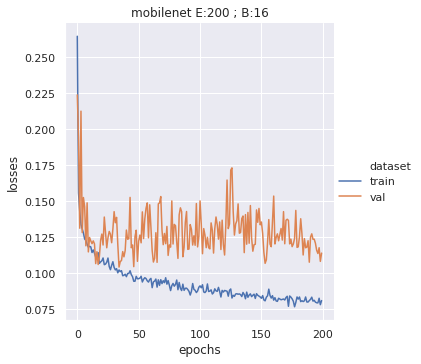

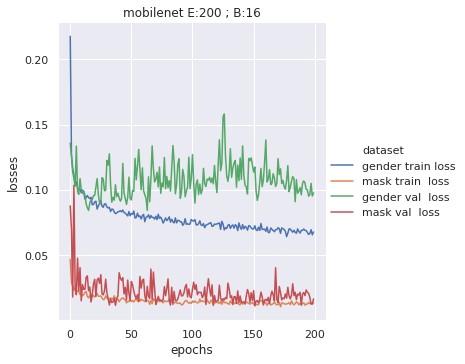

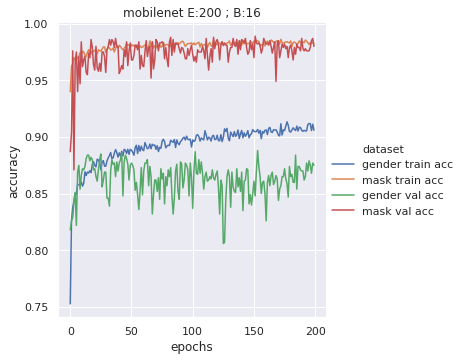

resnet
A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 7s 0us/step
Train for 625 steps, validate on 1000 samples
Epoch 1/20
624/625 [============================>.] - ETA: 0s - loss: 0.5092 - gender_loss: 0.3993 - mask_loss: 0.1099 - gender_acc: 0.8338 - mask_acc: 0.9573
Epoch 00001: val_loss improved from inf to 0.56796, saving model to ./models/model_resnet_E20_B16.h5
625/625 [==============================] - 156s 249ms/step - loss: 0.5088 - gender_loss: 0.3991 - mask_loss: 0.1098 - gender_acc: 0.8340 - mask_acc: 0.9574 - val_loss: 0.5680 - val_gender_loss: 0.3164 - val_mask_loss: 0.2483 - val_gender_acc: 0.8730 - val_mask_acc: 0.9370
Epoch 2/20
624/625 [============================>.] - ETA: 0s - loss: 0.3797 - gender_loss: 0.3142 - mask_loss: 0.0655 - gender_acc: 0.8635 - mask_acc: 0

Epoch 17/20
624/625 [============================>.] - ETA: 0s - loss: 0.2742 - gender_loss: 0.2337 - mask_loss: 0.0405 - gender_acc: 0.8987 - mask_acc: 0.9850
Epoch 00017: val_loss did not improve from 0.45862
625/625 [==============================] - 128s 204ms/step - loss: 0.2741 - gender_loss: 0.2336 - mask_loss: 0.0406 - gender_acc: 0.8988 - mask_acc: 0.9850 - val_loss: 0.7348 - val_gender_loss: 0.2784 - val_mask_loss: 0.4530 - val_gender_acc: 0.8990 - val_mask_acc: 0.9140
Epoch 18/20
624/625 [============================>.] - ETA: 0s - loss: 0.2866 - gender_loss: 0.2453 - mask_loss: 0.0413 - gender_acc: 0.8954 - mask_acc: 0.9851
Epoch 00018: val_loss did not improve from 0.45862
625/625 [==============================] - 127s 203ms/step - loss: 0.2867 - gender_loss: 0.2454 - mask_loss: 0.0413 - gender_acc: 0.8951 - mask_acc: 0.9851 - val_loss: 0.5025 - val_gender_loss: 0.2854 - val_mask_loss: 0.2163 - val_gender_acc: 0.8960 - val_mask_acc: 0.9570
Epoch 19/20
624/625 [===========

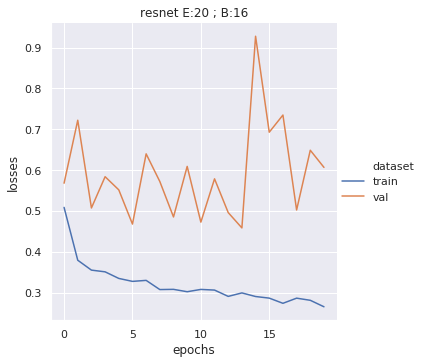

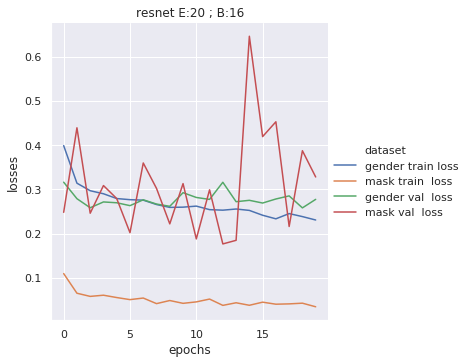

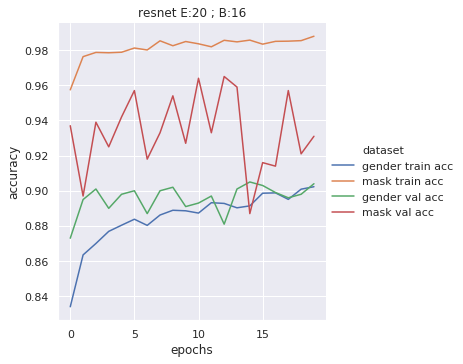

Train for 625 steps, validate on 1000 samples
Epoch 1/60
624/625 [============================>.] - ETA: 0s - loss: 0.5107 - gender_loss: 0.3878 - mask_loss: 0.1228 - gender_acc: 0.8292 - mask_acc: 0.9534
Epoch 00001: val_loss improved from inf to 0.51431, saving model to ./models/model_resnet_E60_B16.h5
625/625 [==============================] - 134s 215ms/step - loss: 0.5106 - gender_loss: 0.3879 - mask_loss: 0.1227 - gender_acc: 0.8293 - mask_acc: 0.9535 - val_loss: 0.5143 - val_gender_loss: 0.3166 - val_mask_loss: 0.1946 - val_gender_acc: 0.8760 - val_mask_acc: 0.9450
Epoch 2/60
624/625 [============================>.] - ETA: 0s - loss: 0.3811 - gender_loss: 0.3081 - mask_loss: 0.0730 - gender_acc: 0.8650 - mask_acc: 0.9731
Epoch 00002: val_loss did not improve from 0.51431
625/625 [==============================] - 127s 204ms/step - loss: 0.3815 - gender_loss: 0.3082 - mask_loss: 0.0732 - gender_acc: 0.8649 - mask_acc: 0.9729 - val_loss: 0.7753 - val_gender_loss: 0.2829 - val_mask

Epoch 18/60
624/625 [============================>.] - ETA: 0s - loss: 0.2891 - gender_loss: 0.2445 - mask_loss: 0.0446 - gender_acc: 0.8975 - mask_acc: 0.9844
Epoch 00018: val_loss did not improve from 0.48692
625/625 [==============================] - 179s 286ms/step - loss: 0.2890 - gender_loss: 0.2444 - mask_loss: 0.0446 - gender_acc: 0.8976 - mask_acc: 0.9844 - val_loss: 0.6037 - val_gender_loss: 0.2721 - val_mask_loss: 0.3278 - val_gender_acc: 0.8960 - val_mask_acc: 0.9350
Epoch 19/60
624/625 [============================>.] - ETA: 0s - loss: 0.2885 - gender_loss: 0.2468 - mask_loss: 0.0417 - gender_acc: 0.8966 - mask_acc: 0.9846
Epoch 00019: val_loss did not improve from 0.48692
625/625 [==============================] - 156s 250ms/step - loss: 0.2887 - gender_loss: 0.2467 - mask_loss: 0.0420 - gender_acc: 0.8968 - mask_acc: 0.9845 - val_loss: 0.6442 - val_gender_loss: 0.2737 - val_mask_loss: 0.3667 - val_gender_acc: 0.8910 - val_mask_acc: 0.9210
Epoch 20/60
624/625 [===========

Epoch 35/60
624/625 [============================>.] - ETA: 0s - loss: 0.2449 - gender_loss: 0.2084 - mask_loss: 0.0365 - gender_acc: 0.9122 - mask_acc: 0.9877
Epoch 00035: val_loss did not improve from 0.48692
625/625 [==============================] - 143s 229ms/step - loss: 0.2463 - gender_loss: 0.2083 - mask_loss: 0.0380 - gender_acc: 0.9122 - mask_acc: 0.9873 - val_loss: 0.6523 - val_gender_loss: 0.2554 - val_mask_loss: 0.3934 - val_gender_acc: 0.9090 - val_mask_acc: 0.9270
Epoch 36/60
624/625 [============================>.] - ETA: 0s - loss: 0.2467 - gender_loss: 0.2109 - mask_loss: 0.0359 - gender_acc: 0.9112 - mask_acc: 0.9878
Epoch 00036: val_loss did not improve from 0.48692
625/625 [==============================] - 151s 242ms/step - loss: 0.2470 - gender_loss: 0.2112 - mask_loss: 0.0358 - gender_acc: 0.9110 - mask_acc: 0.9878 - val_loss: 0.5639 - val_gender_loss: 0.2986 - val_mask_loss: 0.2624 - val_gender_acc: 0.9010 - val_mask_acc: 0.9490
Epoch 37/60
624/625 [===========

Epoch 52/60
624/625 [============================>.] - ETA: 0s - loss: 0.2340 - gender_loss: 0.2019 - mask_loss: 0.0321 - gender_acc: 0.9185 - mask_acc: 0.9897
Epoch 00052: val_loss did not improve from 0.48692
625/625 [==============================] - 153s 245ms/step - loss: 0.2341 - gender_loss: 0.2019 - mask_loss: 0.0322 - gender_acc: 0.9184 - mask_acc: 0.9896 - val_loss: 0.6171 - val_gender_loss: 0.3210 - val_mask_loss: 0.2924 - val_gender_acc: 0.8880 - val_mask_acc: 0.9400
Epoch 53/60
624/625 [============================>.] - ETA: 0s - loss: 0.2311 - gender_loss: 0.1990 - mask_loss: 0.0320 - gender_acc: 0.9226 - mask_acc: 0.9874
Epoch 00053: val_loss did not improve from 0.48692
625/625 [==============================] - 154s 247ms/step - loss: 0.2310 - gender_loss: 0.1990 - mask_loss: 0.0320 - gender_acc: 0.9225 - mask_acc: 0.9874 - val_loss: 0.6867 - val_gender_loss: 0.2868 - val_mask_loss: 0.3962 - val_gender_acc: 0.8990 - val_mask_acc: 0.9260
Epoch 54/60
624/625 [===========

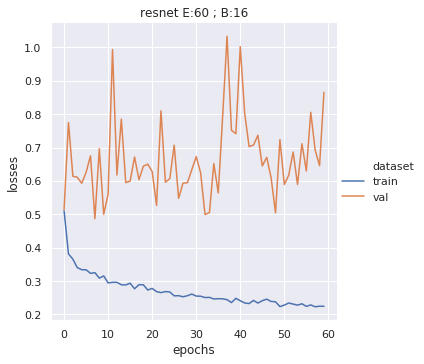

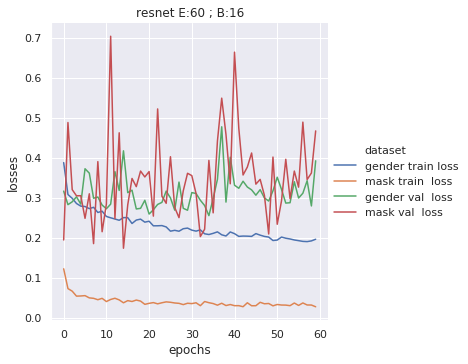

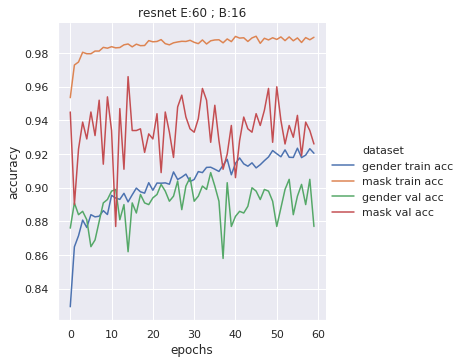

Train for 625 steps, validate on 1000 samples
Epoch 1/200
624/625 [============================>.] - ETA: 0s - loss: 0.4898 - gender_loss: 0.3688 - mask_loss: 0.1210 - gender_acc: 0.8349 - mask_acc: 0.9566  ETA: 14s - lo
Epoch 00001: val_loss improved from inf to 0.47801, saving model to ./models/model_resnet_E200_B16.h5
625/625 [==============================] - 130s 209ms/step - loss: 0.4893 - gender_loss: 0.3685 - mask_loss: 0.1208 - gender_acc: 0.8351 - mask_acc: 0.9567 - val_loss: 0.4780 - val_gender_loss: 0.3056 - val_mask_loss: 0.1718 - val_gender_acc: 0.8770 - val_mask_acc: 0.9530
Epoch 2/200
624/625 [============================>.] - ETA: 0s - loss: 0.3828 - gender_loss: 0.3071 - mask_loss: 0.0757 - gender_acc: 0.8640 - mask_acc: 0.9712
Epoch 00002: val_loss did not improve from 0.47801
625/625 [==============================] - 139s 222ms/step - loss: 0.3824 - gender_loss: 0.3068 - mask_loss: 0.0755 - gender_acc: 0.8641 - mask_acc: 0.9712 - val_loss: 0.5517 - val_gender_loss:

Epoch 18/200
624/625 [============================>.] - ETA: 0s - loss: 0.2800 - gender_loss: 0.2383 - mask_loss: 0.0418 - gender_acc: 0.8957 - mask_acc: 0.9861
Epoch 00018: val_loss did not improve from 0.47607
625/625 [==============================] - 129s 207ms/step - loss: 0.2800 - gender_loss: 0.2383 - mask_loss: 0.0417 - gender_acc: 0.8957 - mask_acc: 0.9861 - val_loss: 0.6717 - val_gender_loss: 0.4547 - val_mask_loss: 0.2124 - val_gender_acc: 0.8580 - val_mask_acc: 0.9550
Epoch 19/200
624/625 [============================>.] - ETA: 0s - loss: 0.2762 - gender_loss: 0.2356 - mask_loss: 0.0406 - gender_acc: 0.8995 - mask_acc: 0.9846
Epoch 00019: val_loss did not improve from 0.47607
625/625 [==============================] - 150s 240ms/step - loss: 0.2758 - gender_loss: 0.2353 - mask_loss: 0.0405 - gender_acc: 0.8997 - mask_acc: 0.9846 - val_loss: 0.5146 - val_gender_loss: 0.2723 - val_mask_loss: 0.2398 - val_gender_acc: 0.8970 - val_mask_acc: 0.9510
Epoch 20/200
624/625 [========

Epoch 35/200
624/625 [============================>.] - ETA: 0s - loss: 0.2536 - gender_loss: 0.2156 - mask_loss: 0.0380 - gender_acc: 0.9090 - mask_acc: 0.9862
Epoch 00035: val_loss did not improve from 0.47607
625/625 [==============================] - 125s 200ms/step - loss: 0.2535 - gender_loss: 0.2156 - mask_loss: 0.0379 - gender_acc: 0.9090 - mask_acc: 0.9862 - val_loss: 0.6504 - val_gender_loss: 0.3420 - val_mask_loss: 0.3045 - val_gender_acc: 0.8770 - val_mask_acc: 0.9400
Epoch 36/200
624/625 [============================>.] - ETA: 0s - loss: 0.2479 - gender_loss: 0.2128 - mask_loss: 0.0351 - gender_acc: 0.9117 - mask_acc: 0.9864
Epoch 00036: val_loss did not improve from 0.47607
625/625 [==============================] - 125s 200ms/step - loss: 0.2475 - gender_loss: 0.2125 - mask_loss: 0.0350 - gender_acc: 0.9117 - mask_acc: 0.9864 - val_loss: 0.6961 - val_gender_loss: 0.3267 - val_mask_loss: 0.3657 - val_gender_acc: 0.8870 - val_mask_acc: 0.9360
Epoch 37/200
624/625 [========

Epoch 52/200
624/625 [============================>.] - ETA: 0s - loss: 0.2174 - gender_loss: 0.1901 - mask_loss: 0.0272 - gender_acc: 0.9215 - mask_acc: 0.9900
Epoch 00052: val_loss did not improve from 0.47607
625/625 [==============================] - 127s 204ms/step - loss: 0.2171 - gender_loss: 0.1899 - mask_loss: 0.0272 - gender_acc: 0.9216 - mask_acc: 0.9900 - val_loss: 0.7469 - val_gender_loss: 0.3519 - val_mask_loss: 0.3906 - val_gender_acc: 0.8850 - val_mask_acc: 0.9350
Epoch 53/200
624/625 [============================>.] - ETA: 0s - loss: 0.2323 - gender_loss: 0.2016 - mask_loss: 0.0307 - gender_acc: 0.9179 - mask_acc: 0.9885
Epoch 00053: val_loss did not improve from 0.47607
625/625 [==============================] - 127s 204ms/step - loss: 0.2321 - gender_loss: 0.2015 - mask_loss: 0.0306 - gender_acc: 0.9178 - mask_acc: 0.9885 - val_loss: 0.5991 - val_gender_loss: 0.2957 - val_mask_loss: 0.3016 - val_gender_acc: 0.8930 - val_mask_acc: 0.9450
Epoch 54/200
624/625 [========

Epoch 69/200
624/625 [============================>.] - ETA: 0s - loss: 0.2217 - gender_loss: 0.1848 - mask_loss: 0.0369 - gender_acc: 0.9225 - mask_acc: 0.9869
Epoch 00069: val_loss did not improve from 0.47607
625/625 [==============================] - 130s 207ms/step - loss: 0.2216 - gender_loss: 0.1846 - mask_loss: 0.0369 - gender_acc: 0.9226 - mask_acc: 0.9869 - val_loss: 0.6439 - val_gender_loss: 0.3942 - val_mask_loss: 0.2472 - val_gender_acc: 0.8790 - val_mask_acc: 0.9600
Epoch 70/200
624/625 [============================>.] - ETA: 0s - loss: 0.2194 - gender_loss: 0.1820 - mask_loss: 0.0374 - gender_acc: 0.9257 - mask_acc: 0.9866
Epoch 00070: val_loss did not improve from 0.47607
625/625 [==============================] - 129s 206ms/step - loss: 0.2191 - gender_loss: 0.1817 - mask_loss: 0.0374 - gender_acc: 0.9258 - mask_acc: 0.9866 - val_loss: 0.7231 - val_gender_loss: 0.4096 - val_mask_loss: 0.3093 - val_gender_acc: 0.8760 - val_mask_acc: 0.9470
Epoch 71/200
624/625 [========

Epoch 86/200
624/625 [============================>.] - ETA: 0s - loss: 0.2031 - gender_loss: 0.1701 - mask_loss: 0.0330 - gender_acc: 0.9299 - mask_acc: 0.9882
Epoch 00086: val_loss did not improve from 0.47607
625/625 [==============================] - 126s 202ms/step - loss: 0.2030 - gender_loss: 0.1701 - mask_loss: 0.0329 - gender_acc: 0.9299 - mask_acc: 0.9882 - val_loss: 0.5563 - val_gender_loss: 0.3695 - val_mask_loss: 0.1851 - val_gender_acc: 0.8870 - val_mask_acc: 0.9670
Epoch 87/200
624/625 [============================>.] - ETA: 0s - loss: 0.2031 - gender_loss: 0.1723 - mask_loss: 0.0308 - gender_acc: 0.9289 - mask_acc: 0.9880
Epoch 00087: val_loss did not improve from 0.47607
625/625 [==============================] - 125s 200ms/step - loss: 0.2029 - gender_loss: 0.1721 - mask_loss: 0.0308 - gender_acc: 0.9290 - mask_acc: 0.9880 - val_loss: 0.5073 - val_gender_loss: 0.3774 - val_mask_loss: 0.1283 - val_gender_acc: 0.8840 - val_mask_acc: 0.9790
Epoch 88/200
624/625 [========

Epoch 103/200
624/625 [============================>.] - ETA: 0s - loss: 0.1890 - gender_loss: 0.1641 - mask_loss: 0.0250 - gender_acc: 0.9353 - mask_acc: 0.9914
Epoch 00103: val_loss did not improve from 0.47607
625/625 [==============================] - 126s 201ms/step - loss: 0.1889 - gender_loss: 0.1640 - mask_loss: 0.0249 - gender_acc: 0.9353 - mask_acc: 0.9914 - val_loss: 0.6818 - val_gender_loss: 0.4355 - val_mask_loss: 0.2428 - val_gender_acc: 0.8730 - val_mask_acc: 0.9590
Epoch 104/200
624/625 [============================>.] - ETA: 0s - loss: 0.2000 - gender_loss: 0.1723 - mask_loss: 0.0277 - gender_acc: 0.9326 - mask_acc: 0.9903
Epoch 00104: val_loss did not improve from 0.47607
625/625 [==============================] - 125s 201ms/step - loss: 0.1998 - gender_loss: 0.1721 - mask_loss: 0.0276 - gender_acc: 0.9326 - mask_acc: 0.9903 - val_loss: 0.6326 - val_gender_loss: 0.4063 - val_mask_loss: 0.2225 - val_gender_acc: 0.8730 - val_mask_acc: 0.9580
Epoch 105/200
624/625 [=====

Epoch 120/200
624/625 [============================>.] - ETA: 0s - loss: 0.1794 - gender_loss: 0.1555 - mask_loss: 0.0240 - gender_acc: 0.9378 - mask_acc: 0.9918
Epoch 00120: val_loss did not improve from 0.47607
625/625 [==============================] - 126s 202ms/step - loss: 0.1794 - gender_loss: 0.1555 - mask_loss: 0.0239 - gender_acc: 0.9377 - mask_acc: 0.9918 - val_loss: 0.6444 - val_gender_loss: 0.4368 - val_mask_loss: 0.2032 - val_gender_acc: 0.8680 - val_mask_acc: 0.9640
Epoch 121/200
624/625 [============================>.] - ETA: 0s - loss: 0.1900 - gender_loss: 0.1645 - mask_loss: 0.0255 - gender_acc: 0.9292 - mask_acc: 0.9897
Epoch 00121: val_loss did not improve from 0.47607
625/625 [==============================] - 126s 202ms/step - loss: 0.1897 - gender_loss: 0.1643 - mask_loss: 0.0255 - gender_acc: 0.9293 - mask_acc: 0.9897 - val_loss: 0.6504 - val_gender_loss: 0.3954 - val_mask_loss: 0.2515 - val_gender_acc: 0.8780 - val_mask_acc: 0.9580
Epoch 122/200
624/625 [=====

Epoch 137/200
624/625 [============================>.] - ETA: 0s - loss: 0.1797 - gender_loss: 0.1527 - mask_loss: 0.0270 - gender_acc: 0.9384 - mask_acc: 0.9907
Epoch 00137: val_loss did not improve from 0.47607
625/625 [==============================] - 126s 201ms/step - loss: 0.1795 - gender_loss: 0.1525 - mask_loss: 0.0270 - gender_acc: 0.9385 - mask_acc: 0.9907 - val_loss: 0.7419 - val_gender_loss: 0.4020 - val_mask_loss: 0.3362 - val_gender_acc: 0.8900 - val_mask_acc: 0.9480
Epoch 138/200
624/625 [============================>.] - ETA: 0s - loss: 0.1804 - gender_loss: 0.1546 - mask_loss: 0.0258 - gender_acc: 0.9372 - mask_acc: 0.9902
Epoch 00138: val_loss did not improve from 0.47607
625/625 [==============================] - 126s 201ms/step - loss: 0.1802 - gender_loss: 0.1544 - mask_loss: 0.0257 - gender_acc: 0.9373 - mask_acc: 0.9902 - val_loss: 0.6808 - val_gender_loss: 0.3988 - val_mask_loss: 0.2783 - val_gender_acc: 0.8850 - val_mask_acc: 0.9530
Epoch 139/200
624/625 [=====

Epoch 154/200
624/625 [============================>.] - ETA: 0s - loss: 0.1754 - gender_loss: 0.1518 - mask_loss: 0.0236 - gender_acc: 0.9395 - mask_acc: 0.9920
Epoch 00154: val_loss did not improve from 0.47607
625/625 [==============================] - 125s 200ms/step - loss: 0.1754 - gender_loss: 0.1518 - mask_loss: 0.0235 - gender_acc: 0.9394 - mask_acc: 0.9920 - val_loss: 0.5926 - val_gender_loss: 0.4001 - val_mask_loss: 0.1901 - val_gender_acc: 0.8800 - val_mask_acc: 0.9700
Epoch 155/200
624/625 [============================>.] - ETA: 0s - loss: 0.1736 - gender_loss: 0.1507 - mask_loss: 0.0229 - gender_acc: 0.9417 - mask_acc: 0.9919
Epoch 00155: val_loss did not improve from 0.47607
625/625 [==============================] - 124s 199ms/step - loss: 0.1734 - gender_loss: 0.1506 - mask_loss: 0.0229 - gender_acc: 0.9418 - mask_acc: 0.9919 - val_loss: 0.6515 - val_gender_loss: 0.4152 - val_mask_loss: 0.2335 - val_gender_acc: 0.8720 - val_mask_acc: 0.9620
Epoch 156/200
624/625 [=====

Epoch 171/200
624/625 [============================>.] - ETA: 0s - loss: 0.1791 - gender_loss: 0.1517 - mask_loss: 0.0274 - gender_acc: 0.9405 - mask_acc: 0.9896
Epoch 00171: val_loss did not improve from 0.47607
625/625 [==============================] - 126s 202ms/step - loss: 0.1789 - gender_loss: 0.1516 - mask_loss: 0.0273 - gender_acc: 0.9406 - mask_acc: 0.9896 - val_loss: 0.6710 - val_gender_loss: 0.4378 - val_mask_loss: 0.2299 - val_gender_acc: 0.8700 - val_mask_acc: 0.9600
Epoch 172/200
624/625 [============================>.] - ETA: 0s - loss: 0.1740 - gender_loss: 0.1496 - mask_loss: 0.0244 - gender_acc: 0.9397 - mask_acc: 0.9916
Epoch 00172: val_loss did not improve from 0.47607
625/625 [==============================] - 122s 195ms/step - loss: 0.1738 - gender_loss: 0.1495 - mask_loss: 0.0244 - gender_acc: 0.9398 - mask_acc: 0.9916 - val_loss: 0.6999 - val_gender_loss: 0.4235 - val_mask_loss: 0.2721 - val_gender_acc: 0.8820 - val_mask_acc: 0.9540
Epoch 173/200
624/625 [=====

Epoch 188/200
624/625 [============================>.] - ETA: 0s - loss: 0.1702 - gender_loss: 0.1441 - mask_loss: 0.0260 - gender_acc: 0.9437 - mask_acc: 0.9900
Epoch 00188: val_loss did not improve from 0.47607
625/625 [==============================] - 124s 199ms/step - loss: 0.1704 - gender_loss: 0.1443 - mask_loss: 0.0261 - gender_acc: 0.9436 - mask_acc: 0.9900 - val_loss: 0.7277 - val_gender_loss: 0.5680 - val_mask_loss: 0.1554 - val_gender_acc: 0.8470 - val_mask_acc: 0.9740
Epoch 189/200
624/625 [============================>.] - ETA: 0s - loss: 0.1646 - gender_loss: 0.1339 - mask_loss: 0.0307 - gender_acc: 0.9491 - mask_acc: 0.9883
Epoch 00189: val_loss did not improve from 0.47607
625/625 [==============================] - 127s 203ms/step - loss: 0.1644 - gender_loss: 0.1337 - mask_loss: 0.0307 - gender_acc: 0.9492 - mask_acc: 0.9883 - val_loss: 0.8267 - val_gender_loss: 0.5680 - val_mask_loss: 0.2524 - val_gender_acc: 0.8620 - val_mask_acc: 0.9520
Epoch 190/200
624/625 [=====

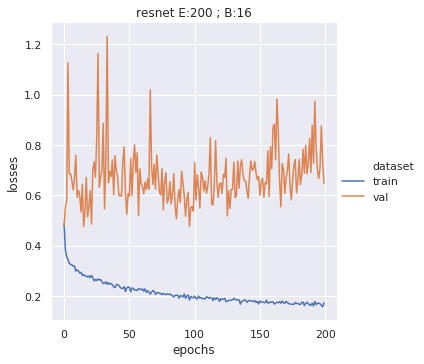

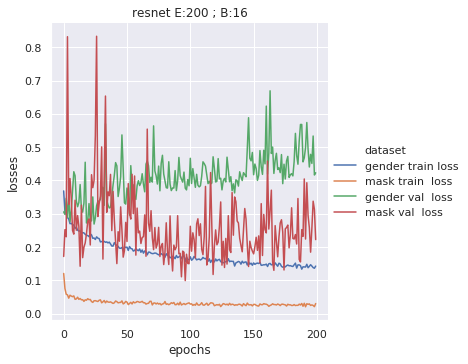

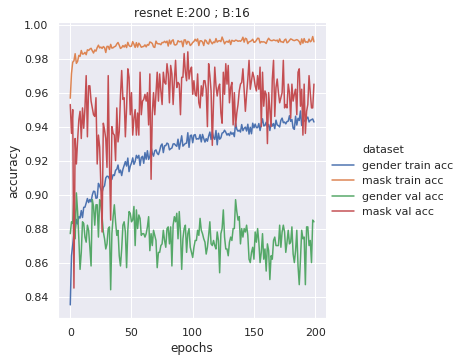

optimized
Train for 625 steps, validate on 1000 samples
Epoch 1/60
624/625 [============================>.] - ETA: 0s - loss: 0.7890 - gender_loss: 0.5405 - mask_loss: 0.2485 - gender_acc: 0.7208 - mask_acc: 0.8949
Epoch 00001: val_loss improved from inf to 0.71100, saving model to ./models/model_optimized_E60_B16.h5
625/625 [==============================] - 122s 195ms/step - loss: 0.7889 - gender_loss: 0.5403 - mask_loss: 0.2486 - gender_acc: 0.7208 - mask_acc: 0.8949 - val_loss: 0.7110 - val_gender_loss: 0.6065 - val_mask_loss: 0.1043 - val_gender_acc: 0.6890 - val_mask_acc: 0.9630
Epoch 2/60
624/625 [============================>.] - ETA: 0s - loss: 0.4086 - gender_loss: 0.3233 - mask_loss: 0.0853 - gender_acc: 0.8564 - mask_acc: 0.9688
Epoch 00002: val_loss improved from 0.71100 to 0.34424, saving model to ./models/model_optimized_E60_B16.h5
625/625 [==============================] - 118s 189ms/step - loss: 0.4081 - gender_loss: 0.3229 - mask_loss: 0.0852 - gender_acc: 0.8565 - ma

Epoch 17/60
624/625 [============================>.] - ETA: 0s - loss: 0.1367 - gender_loss: 0.1247 - mask_loss: 0.0120 - gender_acc: 0.9534 - mask_acc: 0.9963
Epoch 00017: val_loss did not improve from 0.13012
625/625 [==============================] - 120s 192ms/step - loss: 0.1366 - gender_loss: 0.1247 - mask_loss: 0.0119 - gender_acc: 0.9534 - mask_acc: 0.9963 - val_loss: 0.1681 - val_gender_loss: 0.1652 - val_mask_loss: 0.0026 - val_gender_acc: 0.9390 - val_mask_acc: 0.9990
Epoch 18/60
624/625 [============================>.] - ETA: 0s - loss: 0.1393 - gender_loss: 0.1219 - mask_loss: 0.0175 - gender_acc: 0.9529 - mask_acc: 0.9953
Epoch 00018: val_loss did not improve from 0.13012
625/625 [==============================] - 119s 191ms/step - loss: 0.1392 - gender_loss: 0.1217 - mask_loss: 0.0175 - gender_acc: 0.9530 - mask_acc: 0.9952 - val_loss: 0.1481 - val_gender_loss: 0.1377 - val_mask_loss: 0.0100 - val_gender_acc: 0.9490 - val_mask_acc: 0.9960
Epoch 19/60
624/625 [===========

Epoch 34/60
624/625 [============================>.] - ETA: 0s - loss: 0.0847 - gender_loss: 0.0797 - mask_loss: 0.0050 - gender_acc: 0.9712 - mask_acc: 0.9988
Epoch 00034: val_loss improved from 0.10331 to 0.09969, saving model to ./models/model_optimized_E60_B16.h5
625/625 [==============================] - 120s 192ms/step - loss: 0.0847 - gender_loss: 0.0797 - mask_loss: 0.0050 - gender_acc: 0.9712 - mask_acc: 0.9988 - val_loss: 0.0997 - val_gender_loss: 0.1007 - val_mask_loss: 9.0627e-04 - val_gender_acc: 0.9660 - val_mask_acc: 1.0000
Epoch 35/60
624/625 [============================>.] - ETA: 0s - loss: 0.0884 - gender_loss: 0.0822 - mask_loss: 0.0062 - gender_acc: 0.9695 - mask_acc: 0.9981
Epoch 00035: val_loss did not improve from 0.09969
625/625 [==============================] - 119s 191ms/step - loss: 0.0883 - gender_loss: 0.0821 - mask_loss: 0.0062 - gender_acc: 0.9695 - mask_acc: 0.9981 - val_loss: 0.1347 - val_gender_loss: 0.1348 - val_mask_loss: 6.1227e-04 - val_gender_ac

Epoch 51/60
624/625 [============================>.] - ETA: 0s - loss: 0.0550 - gender_loss: 0.0509 - mask_loss: 0.0041 - gender_acc: 0.9802 - mask_acc: 0.9986
Epoch 00051: val_loss did not improve from 0.09232
625/625 [==============================] - 119s 190ms/step - loss: 0.0550 - gender_loss: 0.0509 - mask_loss: 0.0041 - gender_acc: 0.9802 - mask_acc: 0.9986 - val_loss: 0.1415 - val_gender_loss: 0.1418 - val_mask_loss: 0.0010 - val_gender_acc: 0.9630 - val_mask_acc: 1.0000
Epoch 52/60
624/625 [============================>.] - ETA: 0s - loss: 0.0558 - gender_loss: 0.0523 - mask_loss: 0.0035 - gender_acc: 0.9798 - mask_acc: 0.9985
Epoch 00052: val_loss did not improve from 0.09232
625/625 [==============================] - 119s 190ms/step - loss: 0.0558 - gender_loss: 0.0522 - mask_loss: 0.0035 - gender_acc: 0.9798 - mask_acc: 0.9985 - val_loss: 0.1145 - val_gender_loss: 0.1147 - val_mask_loss: 3.6045e-04 - val_gender_acc: 0.9700 - val_mask_acc: 1.0000
Epoch 53/60
624/625 [=======

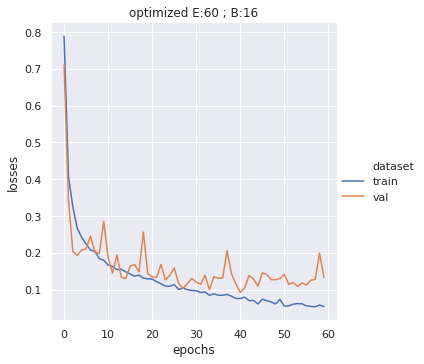

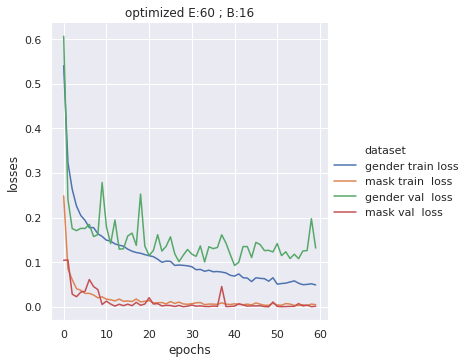

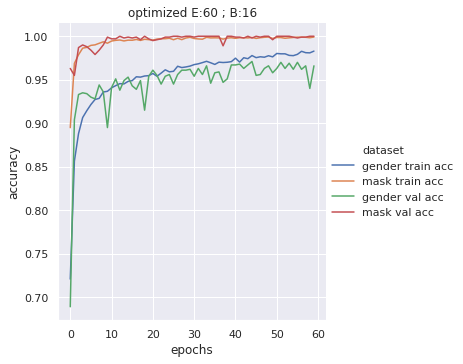

In [10]:
# Generacion de la validacion estatica para todos los modelos y entrenamientos
val   = Generator(partition['validation'],
                  batchSize=len(partition['validation']['img']), data_set='val')
# validacion estatica, no dinamica
imgs_val, labels_val = val[0]
if not os.path.exists('./models'):
    os.mkdir('./models')

models_save = {}

for name_model, model_function in models.items():
    print(name_model)

    if name_model == 'optimized':
        epochs = [60]
        batchs = [16]
    else:
        epochs = [20, 60, 200]
        batchs = [8, 16, 32]

    for epoch in epochs:
#         for batch in batchs:
            batch = 16
            K.clear_session()
            model, preprocess, function_label = model_function()
            # Generacion de entrenamiento dinamico
            train = Generator(partition['train'], batchSize=batch, preprocess=preprocess,
                            label_encoded=function_label)
            
            img_val_for_model = preprocess(np.copy(imgs_val))
            
            labels_val_for_model = {}
            labels_val_for_model['gender'] = function_label(np.copy(labels_val['gender']))
            labels_val_for_model['mask'] = function_label(np.copy(labels_val['mask']))

            filename_best_model = './models/model_{}_E{}_B{}.h5'.format(name_model, epoch, batch)
            callbacks = [ModelCheckpoint(filename_best_model, save_best_only=True, verbose=1)]
            history = model.fit_generator(generator=train, epochs=epoch, verbose=1,
                                        validation_data=[img_val_for_model, labels_val_for_model], shuffle=False,
                                        callbacks=callbacks,
                                        )
            plot_history(history, '{} E:{} ; B:{}'.format(name_model, epoch, batch))
            models_save[name_model] = filename_best_model

K.clear_session()

# Test
se realizara el test en otro notebook